# Preliminary operations

In this first section we install the required libraries and related packages and run a brief summary of the dataset.

In [ ]:
!pip install zipfile-deflate64

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 930 kB/s 


In [ ]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 5.2 MB/s 


In [ ]:
!PYTHONHASHSEED=0

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from matplotlib import pyplot as plt
import copy
import math
import matplotlib
import zipfile_deflate64 as zipfile
from shutil import copyfile
from time import time
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
import random
import cv2
import shutil
import os
import gc
import glob
import json
import ast
from google.colab import drive

print(keras.__version__)
np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

2.8.0


In [ ]:
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
copyfile('/content/gdrive/MyDrive/DeepLearning/LSWMD.pkl.zip','LSWMD.pkl.zip')
zip = zipfile.ZipFile('LSWMD.pkl.zip')
zip.extractall()
zip.close()

In [ ]:
data = pd.read_pickle('LSWMD.pkl')

In [ ]:
data.shape

(811457, 6)

In [ ]:
data.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [ ]:
data['failureType'].map(lambda x: list(x)!=[]).sum()

172950

There are only 172.950 data labelled, which will be used to train the network. We eliminate the rest.

In [ ]:
data_unlabelled = pd.DataFrame()
data_unlabelled = data[data['failureType'].map(lambda x: list(x)==[])]

In [ ]:
data_unlabelled.shape

(638507, 6)

In [ ]:
data_unlabelled.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
35,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,11.0,[],[]
45,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,21.0,[],[]
69,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot3,20.0,[],[]
120,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot5,21.0,[],[]
158,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2,...",533.0,lot7,9.0,[],[]


In [ ]:
data_labelled = pd.DataFrame()
data_labelled = data[data['failureType'].map(lambda x: list(x)!=[])]

In [ ]:
data_labelled.shape

(172950, 6)

In [ ]:
data_labelled.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


We extract the strings from the arrays.

In [ ]:
data_labelled['failureType'] = data_labelled['failureType'].map(lambda x: x[0][0])
data_labelled['trianTestLabel'] = data_labelled['trianTestLabel'].map(lambda x: x[0][0])
data_labelled.rename(columns = {'trianTestLabel':'trainTestLabel'}, inplace = True)

In [ ]:
data_labelled.head()

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none


# Data analysis

Let's analyze different aspects of the dataset. In particular, we focus on critical aspects such as the imbalance between classes, the presence of defective images and the different forms assumed by the images.

In [ ]:
number_labelled_data = data_labelled.shape[0]

In [ ]:
failure_types = list(pd.unique(data_labelled['failureType']))
failure_types

['none',
 'Loc',
 'Edge-Loc',
 'Center',
 'Edge-Ring',
 'Scratch',
 'Random',
 'Near-full',
 'Donut']

In [ ]:
types_image_number = list(map(lambda x: (data_labelled['failureType']==x).sum(), failure_types))
types_image_number

[147431, 3593, 5189, 4294, 9680, 1193, 866, 149, 555]

In [ ]:
types_image_proportion = list(map(lambda x: round(x/number_labelled_data,3), types_image_number))
types_image_proportion

[0.852, 0.021, 0.03, 0.025, 0.056, 0.007, 0.005, 0.001, 0.003]

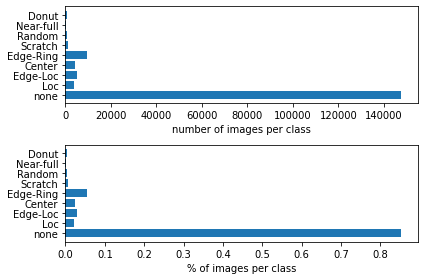

In [ ]:
plt.subplot(2,1,1)
plt.barh(failure_types, types_image_number)
plt.xlabel('number of images per class')

plt.subplot(2,1,2)
plt.barh(failure_types, types_image_proportion)
plt.xlabel('% of images per class')

plt.tight_layout()

In [ ]:
number_failure_images = sum(types_image_number[1:])
number_ok_images = types_image_number[0]

[number_failure_images,number_ok_images]

[25519, 147431]

<BarContainer object of 2 artists>

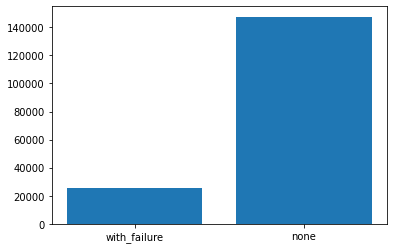

In [ ]:
plt.bar(['with_failure','none'],[number_failure_images,number_ok_images])

As you can see, the dataset is strongly biased towards the none class, that is the one without defects. We will definitely need to do **data augmentation**.

In more detail, let's see if the imbalance also exists with regard to the classes of defects.

Text(0.5, 0, '% of images per class')

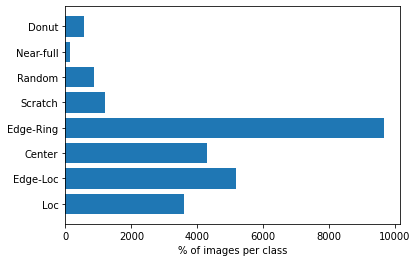

In [ ]:
plt.barh(failure_types[1:], types_image_number[1:])
plt.xlabel('Images per class')

We observe that some classes have a rather lower number of images than the others, so it may be necessary to rebalance the dataset even for the single defective classes.

Let's now display some images for each defect class in order to get an idea of ​​the type of images.

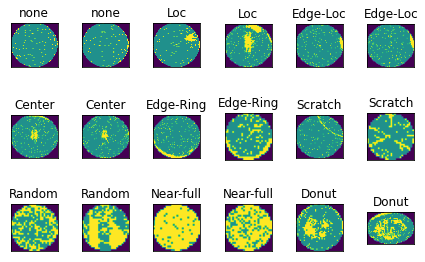

In [ ]:
for i in range(len(failure_types)):
  b = 0
  for j in [0,1]:
    if i != 0:
      b=1
    plt.subplot(3,6,(2*i+1)+j)
    plt.imshow(data_labelled['waferMap'][data_labelled['failureType']==failure_types[i]].iloc[j])
    plt.title(failure_types[i])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

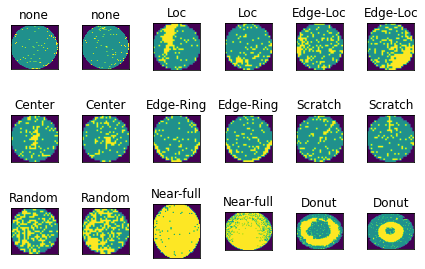

In [ ]:
for i in range(len(failure_types)):
  b = 0
  for j in [0,1]:
    if i != 0:
      b=1
    plt.subplot(3,6,(2*i+1)+j)
    plt.imshow(data_labelled['waferMap'][data_labelled['failureType']==failure_types[i]].iloc[j+10])
    plt.title(failure_types[i])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

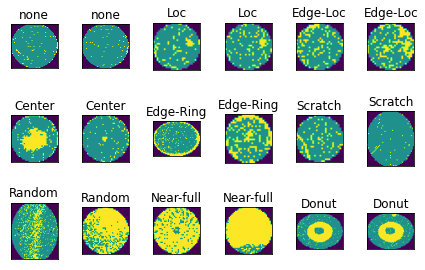

In [ ]:
for i in range(len(failure_types)):
  b = 0
  for j in [0,1]:
    if i != 0:
      b=1
    plt.subplot(3,6,(2*i+1)+j)
    plt.imshow(data_labelled['waferMap'][data_labelled['failureType']==failure_types[i]].iloc[j+20])
    plt.title(failure_types[i])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

As noted above, not all the images have the same shape. It will therefore be necessary to resize them before being able to feed them to a neural network. Let's see in more detail if there is any image with a problematic shape.

In [ ]:
shapes = pd.unique(data_labelled['waferMap'].map(lambda x: x.shape))
shapes.shape

(346,)

There are 346 different shapes assumed by the various images.

In [ ]:
data_labelled['waferMap'].shape

(172950,)

In [ ]:
shapes_sorted_first_dimension = sorted(shapes)
shapes_sorted_second_dimension = sorted(shapes, key=lambda x: x[1])
shapes_sorted_product_dimension = sorted(shapes, key=lambda x: x[0]*x[1])

In [ ]:
shapes_sorted_first_dimension[:5]

[(15, 3), (18, 4), (18, 44), (22, 35), (22, 50)]

In [ ]:
shapes_sorted_second_dimension[:5]

[(15, 3), (18, 4), (24, 13), (27, 15), (40, 18)]

In [ ]:
shapes_sorted_product_dimension[:5]

[(15, 3), (18, 4), (24, 13), (27, 15), (24, 18)]

Let's add a column to the dataset with the shapes of the images.

In [ ]:
data_labelled['shape'] = data_labelled['waferMap'].map(lambda x: x.shape)

In [ ]:
data_labelled.head()

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType,shape
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none,"(45, 48)"


The following figure shows the first image of the dataset for each shape among the 6 smallest (compared to the first dimension).

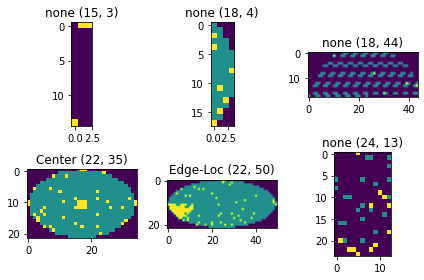

In [ ]:
fig = plt.figure()

for i in range(len(shapes_sorted_first_dimension[:6])):
  data = data_labelled[data_labelled['shape'] == shapes_sorted_first_dimension[i]]
  fig.add_subplot(2,3,i+1)
  plt.imshow(data['waferMap'].iloc[0])
  plt.title(data['failureType'].iloc[0]+' '+str(data['shape'].iloc[0]))

plt.tight_layout()

The following figure shows the first image of the dataset for each shape among the 6 smallest (compared to the second dimension).

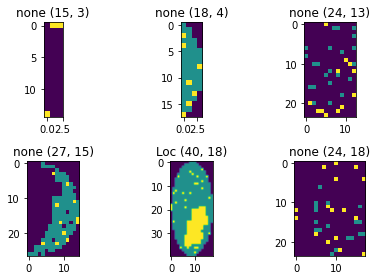

In [ ]:
fig = plt.figure()

for i in range(len(shapes_sorted_second_dimension[:6])):
  data = data_labelled[data_labelled['shape'] == shapes_sorted_second_dimension[i]]
  fig.add_subplot(2,3,i+1)
  plt.imshow(data['waferMap'].iloc[0])
  plt.title(data['failureType'].iloc[0]+' '+str(data['shape'].iloc[0]))

plt.tight_layout()

The following figure shows the first image of the dataset for each shape among the 6 smallest (compared to the product of both dimensions).

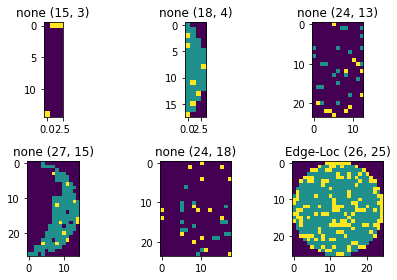

In [ ]:
fig = plt.figure()

for i in range(len(shapes_sorted_second_dimension[:6])):
  data = data_labelled[data_labelled['shape'] == shapes_sorted_product_dimension[i]]
  fig.add_subplot(2,3,i+1)
  plt.imshow(data['waferMap'].iloc[0])
  plt.title(data['failureType'].iloc[0]+' '+str(data['shape'].iloc[0]))

plt.tight_layout()

From the images above it seems that the label *none* has also been assigned to the images acquired in an erroneous way, with a shape that is not attributable to a semiconductor tablet. Furthermore, some images have such a size that it seems appropriate to exclude them from the dataset. In the following we will deepen this analysis.

In [ ]:
shape_image_number = list()
for shape in shapes:
  shape_image_number.append(
      (shape,np.sum([data_labelled['shape']==shape]))
  )

In [ ]:
# The first element of the tuple is the shape
# The second element of the tuple is the numerosity
shape_image_number

[((45, 48), 103),
 ((53, 58), 136),
 ((26, 26), 14366),
 ((70, 58), 24),
 ((60, 40), 25),
 ((37, 37), 376),
 ((37, 55), 25),
 ((41, 57), 24),
 ((39, 39), 30),
 ((62, 75), 118),
 ((50, 43), 423),
 ((43, 43), 36),
 ((36, 34), 139),
 ((42, 43), 447),
 ((75, 63), 23),
 ((32, 36), 3),
 ((102, 66), 17),
 ((54, 71), 206),
 ((29, 29), 17),
 ((38, 45), 1),
 ((41, 41), 1463),
 ((118, 84), 8),
 ((54, 42), 11),
 ((42, 29), 5),
 ((49, 39), 166),
 ((35, 38), 6),
 ((41, 56), 2),
 ((43, 42), 1267),
 ((26, 25), 7),
 ((30, 30), 60),
 ((33, 29), 8125),
 ((34, 34), 708),
 ((52, 55), 100),
 ((35, 31), 4331),
 ((30, 34), 12400),
 ((50, 39), 7),
 ((33, 33), 231),
 ((32, 29), 413),
 ((63, 62), 1424),
 ((34, 35), 15),
 ((39, 31), 454),
 ((38, 36), 2127),
 ((69, 73), 484),
 ((25, 27), 18781),
 ((113, 71), 6),
 ((26, 30), 1513),
 ((29, 30), 9),
 ((40, 40), 242),
 ((87, 89), 5),
 ((70, 36), 2),
 ((56, 41), 235),
 ((89, 76), 29),
 ((52, 59), 186),
 ((33, 24), 22),
 ((36, 36), 29),
 ((45, 46), 8),
 ((76, 64), 2),
 

We graphically display the number of each shape class.

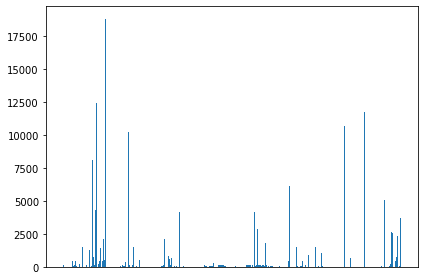

In [ ]:
plt.bar(list(map(lambda x: str(x), shapes)), list(map(lambda x: x[1], shape_image_number)))
plt.xticks([])
plt.tight_layout()

Let's deepen this analysis by verifying the average and median values of the two dimensions of the shape of the images.

In [ ]:
mean_first_dimension =  np.mean(list(map(lambda x: x[0][0], shape_image_number)))
mean_second_dimension = np.mean(list(map(lambda x: x[0][1], shape_image_number)))

In [ ]:
print('mean first dim.',' ', 'mean second dim.')
print(mean_first_dimension, mean_second_dimension)

mean first dim.   mean second dim.
57.73699421965318 57.26589595375722


In [ ]:
median_first_dimension =  np.median(list(map(lambda x: x[0][0], shape_image_number)))
median_second_dimension = np.median(list(map(lambda x: x[0][1], shape_image_number)))

In [ ]:
print('median first dim.', 'median second dim.')
print(median_first_dimension, '            ', median_second_dimension)

median first dim. median second dim.
53.0              52.0


In [ ]:
median_shape = (int(median_first_dimension), int(median_second_dimension))

In [ ]:
list(filter(lambda x: x[0]==median_shape, shape_image_number))

[((53, 52), 1519)]

We observe that there are images with shape (53, 52), which therefore represents the **median** class of the shapes. Let's check some of these images graphically.

In [ ]:
median_images = data_labelled[data_labelled['shape']==median_shape]

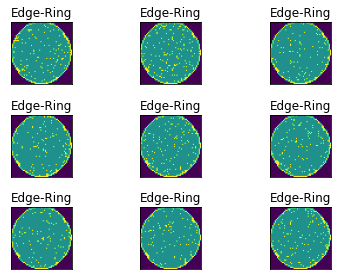

In [ ]:
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(median_images['waferMap'].iloc[i])
  plt.xticks([])
  plt.yticks([])
  plt.title(median_images['failureType'].iloc[i])

plt.tight_layout()

To give all the images the same shape, we choose to bring them back to the median dimension of the dataset which, as already seen, also coincides with one of the 346 shapes assumed by the images.

Given the substantial square shape of the median shape, we check if there are images with a particularly rectangular shape that we could exclude from the dataset. Specifically, the constraint is that one of the two dimensions is at least 50% larger than the other.

In [ ]:
ratio = 1.5
very_rectangular_shapes = list(filter(lambda x: (x[0][0]/x[0][1]>1.5) or (x[0][1]/x[0][0]>1.5), shape_image_number))
len(very_rectangular_shapes)

26

The number of images with a very rectangular shape and the corresponding class is indicated below.

In [ ]:
number_rectangular_per_class = list()

for type_ in failure_types:
  filter1 = data_labelled['failureType'] == type_ 
  data = data_labelled[filter1]
  counter = 0
  for shape in very_rectangular_shapes:
    print(type_, shape)
    filter2 = data_labelled['shape'] == shape[0]
    counter += len(data[filter2])
    
  number_rectangular_per_class.append((type_, counter))

none ((102, 66), 17)
none ((113, 71), 6)
none ((70, 36), 2)
none ((51, 30), 1526)
none ((72, 43), 2)
none ((29, 45), 1)
none ((22, 35), 2)
none ((212, 84), 8)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


none ((26, 50), 1)
none ((40, 18), 3)
none ((43, 133), 1)
none ((38, 62), 1)
none ((122, 204), 3)
none ((101, 65), 123)
none ((98, 64), 9)
none ((75, 48), 3)
none ((22, 50), 899)
none ((72, 44), 45)
none ((63, 160), 11)
none ((131, 66), 3)
none ((88, 56), 11)
none ((24, 13), 1)
none ((18, 4), 1)
none ((15, 3), 1)
none ((27, 15), 1)
none ((18, 44), 1)
Loc ((102, 66), 17)
Loc ((113, 71), 6)
Loc ((70, 36), 2)
Loc ((51, 30), 1526)
Loc ((72, 43), 2)
Loc ((29, 45), 1)
Loc ((22, 35), 2)
Loc ((212, 84), 8)
Loc ((26, 50), 1)
Loc ((40, 18), 3)
Loc ((43, 133), 1)
Loc ((38, 62), 1)
Loc ((122, 204), 3)
Loc ((101, 65), 123)
Loc ((98, 64), 9)
Loc ((75, 48), 3)
Loc ((22, 50), 899)
Loc ((72, 44), 45)
Loc ((63, 160), 11)
Loc ((131, 66), 3)
Loc ((88, 56), 11)
Loc ((24, 13), 1)
Loc ((18, 4), 1)
Loc ((15, 3), 1)
Loc ((27, 15), 1)
Loc ((18, 44), 1)
Edge-Loc ((102, 66), 17)
Edge-Loc ((113, 71), 6)
Edge-Loc ((70, 36), 2)
Edge-Loc ((51, 30), 1526)
Edge-Loc ((72, 43), 2)
Edge-Loc ((29, 45), 1)
Edge-Loc ((22, 35

The tuple indicates, for each class, how many images have a strongly rectangular shape.

In [ ]:
number_rectangular_per_class

[('none', 2381),
 ('Loc', 79),
 ('Edge-Loc', 147),
 ('Center', 15),
 ('Edge-Ring', 20),
 ('Scratch', 34),
 ('Random', 6),
 ('Near-full', 0),
 ('Donut', 0)]

Most of the images belong to the **none** class, which we know to be much more numerous than the others.

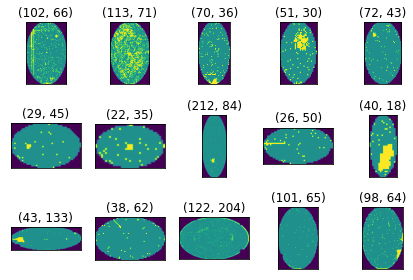

In [ ]:
for i in range(15):
  plt.subplot(3,5,i+1)
  filter = data_labelled['shape']==very_rectangular_shapes[i][0]
  im = data_labelled[filter]['waferMap'].iloc[0]
  plt.imshow(im)
  plt.xticks([])
  plt.yticks([])
  plt.title(data_labelled[filter]['shape'].iloc[0])

plt.tight_layout()

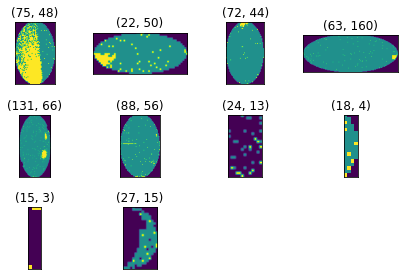

In [ ]:
for i in range(15,25):
  plt.subplot(3,4,i+1-15)
  filter = data_labelled['shape']==very_rectangular_shapes[i][0]
  im = data_labelled[filter]['waferMap'].iloc[0]
  plt.imshow(im)
  plt.xticks([])
  plt.yticks([])
  plt.title(data_labelled[filter]['shape'].iloc[0])

plt.tight_layout()

We observe that some images with rectangular shape are also defective.

# Data cleaning

In this phase we clean up the dataset of defective or excessively rectangular images.

Let's get rid of excessively rectangular images first.

In [ ]:
print(len(data_labelled))
data_labelled = data_labelled.reset_index(drop = True)

for shape in very_rectangular_shapes:
  data_labelled = data_labelled[data_labelled['shape'] != shape[0]]

print(len(data_labelled))

172950
170268


In [ ]:
data_labelled = data_labelled.reset_index(drop = True)
data_labelled.tail()

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType,shape
170263,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc,"(26, 30)"
170264,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc,"(26, 30)"
170265,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring,"(26, 30)"
170266,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc,"(26, 30)"
170267,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,Test,Edge-Ring,"(26, 30)"


We update the number of shapes.

In [ ]:
shapes = pd.unique(data_labelled['waferMap'].map(lambda x: x.shape))
shapes.shape

(320,)

In [ ]:
shape_image_number = list()
for shape in shapes:
  shape_image_number.append(
      (shape,np.sum([data_labelled['shape']==shape]))
  )

We divide the images by shape and we count, for each shape, the average proportion between pixels reserved for the chip and pixels reserved for the background.

In [ ]:
count_pixel = [0]*320
for i in range(len(shapes)):
  
  area = np.product(shapes[i])
  filtered_data = data_labelled[data_labelled['shape']==shapes[i]]
  count1 = sum(list(map(lambda x: list(x.reshape(area)).count(1),filtered_data['waferMap'])))
  count2 = sum(list(map(lambda x: list(x.reshape(area)).count(2),filtered_data['waferMap'])))
  total_pixel_no_background = count1 + count2
  total_area = shape_image_number[i][1]*area
  if (i%50==0):
    print(area, total_pixel_no_background, total_area)
  count_pixel[i] = total_pixel_no_background/total_area


2160 173352 222480
792 13354 17424
1024 622911 804864
1980 214524 277200
1722 32712 41328
4761 22584 28566
2597 3970 5194


In [ ]:
count_pixel[:10]

[0.7791801510248112,
 0.8002602472348731,
 0.7884401203696763,
 0.8123152709359606,
 0.815,
 0.7962832009698024,
 0.7960687960687961,
 0.7753530166880617,
 0.7740959894806049,
 0.7963440860215054]

Let's see first which are the shapes with the greater average background pixel.

In [ ]:
print('id',' shape','   mean')
for i in range(len(count_pixel)):
  if(count_pixel[i] < 0.7):
    print(i,shapes[i],count_pixel[i])

id  shape    mean
179 (84, 74) 0.1751930501930502
309 (24, 18) 0.0787037037037037
310 (53, 71) 0.6736646292851448


Let's save the indices of the defective images for each shape, i.e. with very low non-background pixel ratio (less than 0.6).

In [ ]:
defect = []
defect2 = []

for i in range(len(data_labelled)):
  if(i%10000==0):
    print(i)
  area = np.product(data_labelled['shape'].iloc[i])
  count1 = list(data_labelled['waferMap'].iloc[i].reshape(area)).count(1)
  count2 = list(data_labelled['waferMap'].iloc[i].reshape(area)).count(2)
  pixel_no_background = count1 + count2
  proportion = pixel_no_background/area
  if(proportion < 0.6):
    defect.append(i)
  if(0.6 <= proportion <= 0.7 ):
    defect2.append(i)

In [ ]:
defect[:10]

[16176, 16177, 16178, 16179, 16180, 16181, 16182, 16183, 16184, 16185]

In [ ]:
print(len(defect))

22


We display the defective images (proportion < 0.6).

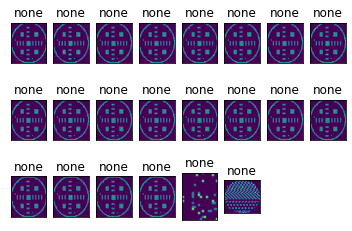

In [ ]:
for i in range(len(defect)):
  plt.subplot(3,8,i+1)
  plt.imshow(data_labelled['waferMap'].iloc[defect[i]])
  plt.xticks([])
  plt.yticks([])
  plt.title(data_labelled['failureType'].iloc[defect[i]])

Instead, we observe that for images with a proportion greater than 0.6 the shape of the wafer is well identifiable.

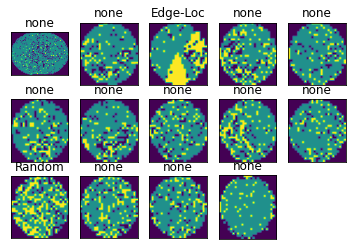

In [ ]:
for i in range(len(defect2)):
  plt.subplot(3,5,i+1)
  plt.imshow(data_labelled['waferMap'].iloc[defect2[i]])
  plt.xticks([])
  plt.yticks([])
  plt.title(data_labelled['failureType'].iloc[defect2[i]])

There are 22 defective images. We save the indexes.

In [ ]:
dict_ = {'Indici': defect}  
df = pd.DataFrame(dict_) 
df.to_csv('/content/gdrive/MyDrive/DeepLearning/Indici_immagini_difettose.csv')

We eliminate the defective images.

In [ ]:
to_delete = pd.read_csv("/content/gdrive/MyDrive/DeepLearning/Indici_immagini_difettose.csv")

for el in to_delete['Indici']:
  data_labelled.drop(el, axis = 0, inplace = True)
data_labelled = data_labelled.reset_index(drop = True)
data_labelled.tail()

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType,shape
170241,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,Test,Edge-Loc,"(26, 30)"
170242,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,Test,Edge-Loc,"(26, 30)"
170243,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,Test,Edge-Ring,"(26, 30)"
170244,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,Test,Edge-Loc,"(26, 30)"
170245,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,Test,Edge-Ring,"(26, 30)"


Now we have the dataset cleansed of flawed and unbalanced images. Let's save it.

In [ ]:
result = data_labelled.to_json(orient = "split")
parsed = json.loads(result)

with open('/content/gdrive/MyDrive/DeepLearning/WM811K_clean.json', 'w') as f:
    json.dump(parsed, f)

# Data preparation

Once we have cleaned the dataset of defective images, we can work with the remaining **170246** images. First of all, we eliminate the useless columns, i.e. dieSize, lotName, waferIndex, trainTestLabel, shape.

The two remaining columns represent the image pixels and the type of anomaly, one of **9 classes**: Center, Donut, Edge-Loc, Edge-Ring, Loc, Near-full, Random, Scratch, none. The pixels instead can assume 3 possible values:

* **0**: Background;
* **1**: Normal chip;
* **2**: Abnormal chip.

The classes are very unbalanced, so we will need to do **data augmentation**.

Finally, in this phase we divide the dataset between training-set (80%) and test-set (20%).

In [ ]:
with open('/content/gdrive/MyDrive/DeepLearning/WM811K_clean.json', 'r') as f:
  data = json.load(f)

In [ ]:
cols = data['columns']
cols

['waferMap',
 'dieSize',
 'lotName',
 'waferIndex',
 'trainTestLabel',
 'failureType',
 'shape']

In [ ]:
dict_ = dict()

for col in cols:
  dict_[col] = list()

for i in range(len(cols)):
  for j in range(len(data['data'])):
    if i == 6:
      dict_[cols[i]].append(tuple(data['data'][j][i]))
    elif i == 5:
      dict_[cols[i]].append(np.array(data['data'][j][i]))
    else:
      dict_[cols[i]].append(data['data'][j][i])

In [ ]:
data = pd.DataFrame(dict_)
data.head()

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType,shape
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,Training,none,"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,Training,none,"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,Training,none,"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,Training,none,"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,Training,none,"(45, 48)"


We eliminate the columns that we do not need.

In [ ]:
data.drop(['dieSize', 'lotName', 'waferIndex', 'trainTestLabel', 'shape'], axis = 1, inplace = True)
data.head()

,waferMap,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none


In [ ]:
failure_types = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]

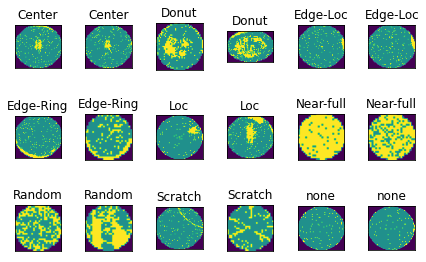

In [ ]:
for i in range(len(failure_types)):
  b = 0
  for j in [0,1]:
    if i != 0:
      b=1
    plt.subplot(3,6,(2*i+1)+j)
    plt.imshow(data['waferMap'][data['failureType'] == failure_types[i]].iloc[j])
    plt.title(failure_types[i])
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

We divide between training and test, putting the test data in a separate list.

In [ ]:
classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]
training = [0] * 9
test = [0] * 9

for i in range(9):
  training[i] = data[data['failureType'] == classes[i]]
  test[i] = training[i].sample(frac = 0.2)
  training[i] = training[i].drop(test[i].index)

In [ ]:
print(sum(len(i) for i in training))
print(sum(len(i) for i in test))

136196
34050


In [ ]:
training[0].head()

,waferMap,failureType
43,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
543,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1,...",Center
645,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1,...",Center
783,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2,...",Center
2249,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1,...",Center


We have 136196 training data and 34050 test data.

# Data augmentation

Before proceeding with augmentation, it is necessary to resize the data to the median shape (53, 52). So, we apply **padding** to the dimensions, so that they become (53, 52) or multiples. Once the images are resized, we increase the data in two stages: in the first we add "hand-made" images to rebalance the anomalous classes, in the second we apply **flipping** and **rotation** to each anomalous image. In particular:

* We do not apply color changes because there are only 3 types of pixels, one of which is for the background.
* We get to 3000 images for the **donut**, **loc**, **near-full**, **random** and **scratch** classes. The idea is to take an image with no defective chips as a template and change the pixels from 1 (chip ok) to 2 (defective chip), based on the class to be increased. For donut, for example, we would have to create "donuts" of anomalous pixels. After that, all anomalous classes will have 3000 instances (except those that already have more than 3000).
* Through a simple neural network, trained on the training data not augmented for 3 epochs, we evaluate the goodness of the hand-crafted augmentation.
* Next, we apply flipping (horizontal and vertical) and 90° rotation (right and left) to each anomalous image.

Eventually the dataset will contain the following images:

* Center: 17115
* Donut: 15000
* Edge-Loc: 20170
* Edge-Ring: 38640
* Loc: 15000
* Near-full: 15000
* Random: 15000
* Scratch: 15000
* None: 116022

A total of 266947 training images.

First of all, let's see the number of classes.

In [ ]:
classes = failure_types

for i in range(len(training)):
  print(classes[i])
  print(len(training[i]))
  print(len(test[i]))

Center
3423
856
Donut
444
111
Edge-Loc
4034
1008
Edge-Ring
7728
1932
Loc
2811
703
Near-full
119
30
Random
688
172
Scratch
927
232
none
116022
29006


Let's reset the indexes.

In [ ]:
for i in range(len(training)):
  training[i] =  training[i].reset_index(drop = True)
  test[i] =  test[i].reset_index(drop = True)

## Resizing

We define a padding function that adds background pixels to the images, in order to make the dimensions of the new shape multiple of 53 and 52 respectively. So, the visual appearance of the images, when resizing to the shape (53, 52) has not changed.

In [ ]:
def apply_padding(a):
  dim1, dim2 = a.shape
  pad11 = 0
  pad12 = 0
  pad21 = 0
  pad22 = 0
  if(dim1 < 53):
    pad11 = int((53 - dim1)/2)
    pad12 = 53 - dim1 - pad11
  if(dim2 < 52):
    pad21 = int((52 - dim2)/2)
    pad22 = 52 - dim2 - pad21
  if(dim1 > 53):
    pad11 = int((math.ceil(dim1/53) * 53 - dim1)/2)
    pad12 = math.ceil(dim1/53) * 53 - dim1 - pad11
  if(dim2 > 52):
    pad21 = int((math.ceil(dim2/52) * 52 - dim2)/2)
    pad22 = math.ceil(dim2/52) * 52 - dim2 - pad21

  return np.pad(a, ((pad11,pad12),(pad21,pad22)), 'constant', constant_values = ((0,0),(0,0)))

We do padding on the training data.

In [ ]:
training_padded = copy.deepcopy(training)

for i in range(len(training_padded)):
  for j in range(len(training_padded[i]['waferMap'])):
    if (j % 500 == 0):
      print(i, j)
    training_padded[i]['waferMap'][j] = np.array(training_padded[i]['waferMap'][j])
    training_padded[i]['waferMap'][j] = apply_padding(training_padded[i]['waferMap'][j])

We do padding on the test data.

In [ ]:
test_padded = copy.deepcopy(test)

for i in range(len(test_padded)):
  for j in range(len(test_padded[i]['waferMap'])):
    if (j % 500 == 0):
      print(i, j)
    test_padded[i]['waferMap'][j] = np.array(test_padded[i]['waferMap'][j])
    test_padded[i]['waferMap'][j] = apply_padding(test_padded[i]['waferMap'][j])

Now, let's resize the padded training data. We use **nearest** as type of interpolation, so that the modified images still have pixels that assume value:

- 0: background;
- 1: chip ok;
- 2: anomalous chip.

In [ ]:
training_padded_resize = copy.deepcopy(training_padded)

resize_model = keras.Sequential(keras.layers.Resizing(53, 52, interpolation = 'nearest'))

for i in range(len(training_padded_resize)):
  for j in range(len(training_padded_resize[i])):
    if(j % 500 == 0):
      print(i, j)
    img = tf.constant([training_padded_resize[i]['waferMap'][j]])
    img = tf.constant(np.moveaxis(img, 0, -1))
    training_padded_resize[i]['waferMap'][j] = (np.array(tf.squeeze(resize_model(img)))).astype(int)

We verify that indeed all the images now have the same shape.

In [ ]:
for i in range(9):
  print(np.unique(list(map(lambda x: x.shape, training_padded_resize[i]['waferMap']))))

[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]


Let's check the images graphically.

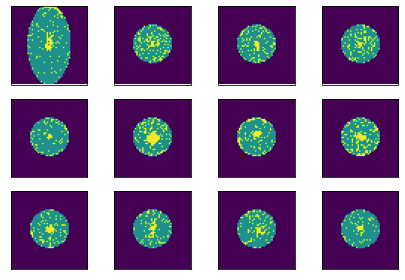

In [ ]:
for i in range(12):
  plt.subplot(3,4,i+1)
  plt.imshow(training_padded_resize[0]['waferMap'][i])
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()

We check that, having used **nearest neighborhood** as interpolation method, no images with pixels other than 0, 1 and 2 have been created.

In [ ]:
for i in range(9):
  for j in range(len(training_padded_resize[i]['waferMap'])):
    correct_pixel = sum(
        list(
            map(
                lambda x: list(x).count(0)+list(x).count(1)+list(x).count(2), 
                training_padded_resize[i]['waferMap'][j]
                )
            )
        )
    if(correct_pixel != 53 * 52):
      print('Ops', i, j)
      break
print('OK')

OK


Let's save the resized training data in JSON.

In [ ]:
training_preprocessed = pd.concat([training_padded_resize[0],training_padded_resize[1],training_padded_resize[2],
                        training_padded_resize[3],training_padded_resize[4],training_padded_resize[5],
                        training_padded_resize[6],training_padded_resize[7],training_padded_resize[8]])
del training_padded_resize

training_preprocessed['failureType'] = list(map(lambda x: str(x), training_preprocessed['failureType']))

parsed = json.loads(training_preprocessed.to_json(orient = "split"))
del training_preprocessed

with open('/content/gdrive/MyDrive/DeepLearning/WM811K_train_padded_resized_not_augmented.json','w') as f:
    json.dump(parsed, f)
del parsed

And now let's do the same thing with the test data.

In [ ]:
test_padded_resize = copy.deepcopy(test_padded)

resize_model = keras.Sequential(keras.layers.Resizing(53, 52, interpolation = 'nearest'))

for i in range(len(test_padded_resize)):
  for j in range(len(test_padded_resize[i])):
    if(j % 500 == 0):
      print(i, j)
    img = tf.constant([test_padded_resize[i]['waferMap'][j]])
    img = tf.constant(np.moveaxis(img, 0, -1))
    test_padded_resize[i]['waferMap'][j] = (np.array(tf.squeeze(resize_model(img)))).astype(int)

In [ ]:
for i in range(9):
  print(np.unique(list(map(lambda x: x.shape, test_padded_resize[i]['waferMap']))))

[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]
[52 53]


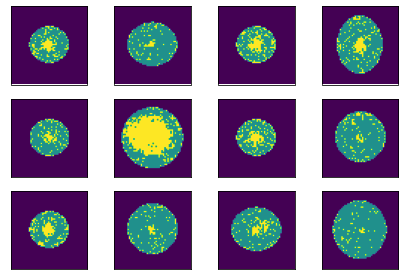

In [ ]:
for i in range(12):
  plt.subplot(3,4,i+1)
  plt.imshow(test_padded_resize[0]['waferMap'][i])
  plt.xticks([])
  plt.yticks([])

plt.tight_layout()

In [ ]:
for i in range(9):
  for j in range(len(test_padded_resize[i]['waferMap'])):
    correct_pixel = sum(
        list(
            map(
                lambda x: list(x).count(0)+list(x).count(1)+list(x).count(2), 
                test_padded_resize[i]['waferMap'][j]
                )
            )
        )
    if(correct_pixel != 53 * 52):
      print('Ops', i, j)
      break
print('OK')

OK


We save the resized test data in JSON.

In [ ]:
test_preprocessed = pd.concat([test_padded_resize[0],test_padded_resize[1],test_padded_resize[2],
                        test_padded_resize[3],test_padded_resize[4],test_padded_resize[5],
                        test_padded_resize[6],test_padded_resize[7],test_padded_resize[8]])
del test_padded_resize

test_preprocessed['failureType'] = list(map(lambda x: str(x), test_preprocessed['failureType']))

parsed = json.loads(test_preprocessed.to_json(orient = "split"))
del test_preprocessed

with open('/content/gdrive/MyDrive/DeepLearning/WM811K_test_padded_resized_not_augmented.json','w') as f:
    json.dump(parsed, f)
del parsed

## Hand-crafted over-sampling

We open the JSON containing the padded and resized training data.

In [ ]:
with open('/content/gdrive/MyDrive/DeepLearning/WM811K_train_padded_resized_not_augmented.json', 'r') as f:
  data_pad_resize = json.load(f)

In [ ]:
cols = data_pad_resize['columns']
cols

['waferMap', 'failureType']

In [ ]:
dict_ = dict()

for col in cols:
  dict_[col] = list()

for i in range(len(cols)):
  for j in range(len(data_pad_resize['data'])):
    if i == 0:
      dict_[cols[i]].append(data_pad_resize['data'][j][i])
    elif i == 1:
      dict_[cols[i]].append(data_pad_resize['data'][j][i])

In [ ]:
data_pad_resize = pd.DataFrame(dict_)
data_pad_resize.head()

,waferMap,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center


In [ ]:
classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]
training_aug_padded = [0] * 9

for i in range(9):
  training_aug_padded[i] = data_pad_resize[data_pad_resize['failureType'] == classes[i]]

In [ ]:
for i in range(len(training_aug_padded)):
  training_aug_padded[i] =  training_aug_padded[i].reset_index(drop = True)

In [ ]:
print(sum(len(i) for i in training_aug_padded))

136196


In [ ]:
training_aug_padded[8].head()

,waferMap,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none


Let's take an image with shape (53, 52) as original template. From this, we create new defective images for the various classes to be oversampled.

We always consider the starting template size **(53, 52)** and always introduce some **random noise** at the end.

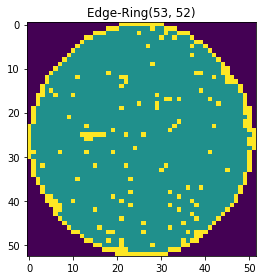

In [ ]:
plt.imshow(training_aug_padded[3]['waferMap'][6000])
plt.title(str(training_aug_padded[3]['failureType'][6000])+str(np.array(training_aug_padded[3]['waferMap'][6000]).shape))

plt.tight_layout()

Let's clean the image of defective chips.

In [ ]:
template = copy.deepcopy(training_aug_padded[3]['waferMap'][6000])
for i in range(len(template)):
  for j in range(len(template[0])):
    if(template[i][j] == 2):
      template[i][j] = 1

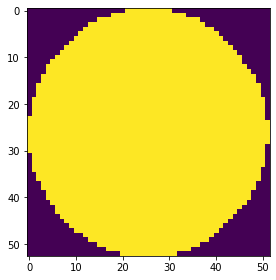

In [ ]:
plt.imshow(template)

plt.tight_layout()

In order to create **donut** anomalies we have to introduce defective donut-shaped chips into the image.

In [ ]:
# Euclidean distance
for n in range(2556):
  img = copy.deepcopy(template)
  for i in range(len(img)):
    for j in range(len(img[i])):
      if(img[i][j] == 1):
        dist = np.sqrt((i-26)**2 + (j-26)**2) 
        if(2.5 <= dist < 5):
          if(random.random() <= 0.1):
            img[i][j] = 2
        if(5 <= dist < 10):
          if(random.random() <= 0.5):
            img[i][j] = 2
        if(10 <= dist <= 17):
          if(random.random() <= 0.7):
            img[i][j] = 2
        if(17 < dist <= 20):
          if(random.random() <= 0.5):
            img[i][j] = 2
        if(20 < dist <= 24):
          if(random.random() <= 0.1):
            img[i][j] = 2
      # Let's add random mutations to the whole picture
      if(random.random() <= 0.05):
        if(img[i][j] == 1):
          img[i][j] = 2
        elif(img[i][j] == 2):
          img[i][j] = 1
  training_aug_padded[1].loc[training_aug_padded[1].shape[0]] = [img, np.array('Donut')]

3000


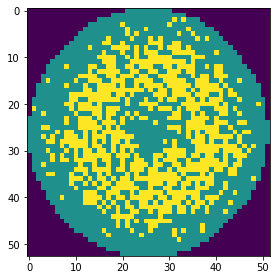

In [ ]:
print(len(training_aug_padded[1]))
plt.imshow(training_aug_padded[1]['waferMap'][2999])

plt.tight_layout()

In order to create **loc** anomalies we have to introduce defective chip areas into the image, being careful not to do it on the edge, otherwise we have the edge-loc class.

In [ ]:
for n in range(189):
  img = copy.deepcopy(template)
  n_loc = random.randint(1, 3)
  for i in range(n_loc):
  # Loc doesn't have to be edge!
    loc_x = random.randint(12, 38)
    loc_y = random.randint(12, 38)
    ray_x = random.randint(2, 8)
    ray_y = random.randint(2, 8)
    for i in range(loc_x - ray_x, loc_x + ray_x):
      for j in range(loc_y - ray_y, loc_y + ray_y):
        if(img[i][j] == 1):
          img[i][j] = 2
        # Let's add random mutations to the loc anomaly
        if(random.random() <= 0.05):
          if(img[i][j] == 1):
            img[i][j] = 2
          elif(img[i][j] == 2):
            img[i][j] = 1
  # Let's add random mutations to the whole picture
  for i in range(len(img)):
      for j in range(len(img[i])):
        if(random.random() <= 0.03):
          if(img[i][j] == 1):
            img[i][j] = 2
          elif(img[i][j] == 2):
              img[i][j] = 1
  training_aug_padded[4].loc[training_aug_padded[4].shape[0]] = [img, np.array('Loc')]

3000


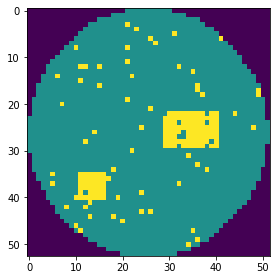

In [ ]:
print(len(training_aug_padded[4]))
plt.imshow(training_aug_padded[4]['waferMap'][2999])

plt.tight_layout()

In order to create **near-full** anomalies we simply need to set almost all the pixels of the image to 2, i.e. set almost all pixels as anomalous.

In [ ]:
for n in range(2881):
  img = copy.deepcopy(template)
  for i in range(len(img)):
    for j in range(len(img[i])):
      if(img[i][j] != 0):
        if(random.random() <= 0.9):
          img[i][j] = 2
        else:
          img[i][j] = 1
  training_aug_padded[5].loc[training_aug_padded[5].shape[0]] = [img, np.array('Near-full')]

3000


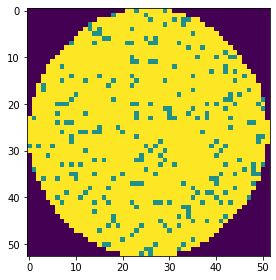

In [ ]:
print(len(training_aug_padded[5]))
plt.imshow(training_aug_padded[5]['waferMap'][2999])

plt.tight_layout()

In order to create **random** anomalies we set the image pixels randomly, with a proportion of anomalous chips varying between 0.25 and 0.45, guaranteeing variability without however ending up in the none or near-full class.

In [ ]:
for n in range(2312):
  img = copy.deepcopy(template)
  max = random.uniform(0.25, 0.45)
  for i in range(len(img)):
    for j in range(len(img[i])):
      k = random.random()
      if(k <= max):
        if(img[i][j] == 1):
          img[i][j] = 2
        elif(img[i][j] == 2):
          img[i][j] = 1
  training_aug_padded[6].loc[training_aug_padded[6].shape[0]] = [img, np.array('Random')]

3000


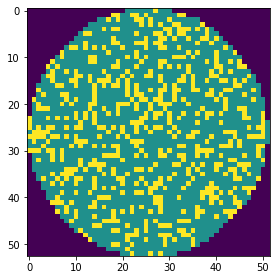

In [ ]:
print(len(training_aug_padded[6]))
plt.imshow(training_aug_padded[6]['waferMap'][2999])

plt.tight_layout()

In order to create **scratch** anomalies we need to create anomalous pixel curves within each image. Let's suppose to create, for each image, from 1 to 3 scratches, randomly. In the same way, we have to choose the starting point and the ending point of each scratch, favoring the edge. Let's suppose the thickness varies between 1 and 2 pixels and the length between 8 and 20 pixels.

In [ ]:
for n in range(2073):
  img = copy.deepcopy(template)
  n_scratch = random.randint(1, 3)

  for _ in range(n_scratch):
    # Scratch starting point
    y_start = random.randint(0, 52)
    x_start = random.randint(0, 51)
    dist = np.sqrt((y_start-26)**2 + (x_start-26)**2) 
    trovato = False
    while(not trovato):
      if((img[y_start][x_start] != 0) and (dist > 24)):
        trovato = True
      else:
        y_start = random.randint(0, 52)
        x_start = random.randint(0, 51)
        dist = np.sqrt((y_start-26)**2 + (x_start-26)**2)

    # Choosing moving direction and intensity 
    move = random.randint(8, 20)
    x = x_start
    y = y_start
    if(x_start < 26 and y_start > 26):
      # Starting from the bottom left
      for k in range(move):
        if(random.random() < 0.7):
          j = x + 1
        else:
          j = x
        i = y - 1
        if(i < 52 and j < 51):
          if(img[i][j] != 0):
            img[i][j] = 2
            if(random.random() < 0.05):
              img[i][j-1] = 2
            if(random.random() < 0.05):
              img[i][j+1] = 2
          x = j
          y = i
    elif(x_start < 26 and y_start <= 26):
      # Starting from the top left
      for k in range(move):
        if(random.random() < 0.7):
          j = x + 1
        else:
          j = x
        i = y + 1
        if(i < 52 and j < 51):
          if(img[i][j] != 0):
            img[i][j] = 2
            if(random.random() < 0.05):
              img[i][j-1] = 2
            if(random.random() < 0.05):
              img[i][j+1] = 2
          x = j
          y = i
    elif(x_start >= 26 and y_start > 26):
      # Starting from the bottom right
      for k in range(move):
        if(random.random() < 0.7):
          j = x - 1
        else:
          j = x
        i = y - 1
        if(i < 52 and j < 51):
          if(img[i][j] != 0):
            img[i][j] = 2
            if(random.random() < 0.05):
              img[i][j-1] = 2
            if(random.random() < 0.05):
              img[i][j+1] = 2
          x = j
          y = i
    elif(x_start >= 26 and y_start <= 26):
      # Starting from the top right
      for k in range(move):
        if(random.random() < 0.7):
          j = x - 1
        else:
          j = x
        i = y + 1
        if(i < 52 and j < 51):
          if(img[i][j] != 0):
            img[i][j] = 2
            if(random.random() < 0.05):
              img[i][j-1] = 2
            if(random.random() < 0.05):
              img[i][j+1] = 2
          x = j
          y = i

  # Let's add random mutations to the whole picture
  for i in range(len(img)):
    for j in range(len(img[i])):
      if(random.random() <= 0.03):
        if(img[i][j] == 1):
          img[i][j] = 2
        elif(img[i][j] == 2):
          img[i][j] = 1

  training_aug_padded[7].loc[training_aug_padded[7].shape[0]] = [img, np.array('Scratch')]

3000


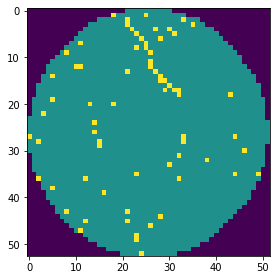

In [ ]:
print(len(training_aug_padded[7]))
plt.imshow(training_aug_padded[7]['waferMap'][2999])

plt.tight_layout()

Let's save the augmented training images in JSON.

In [ ]:
aug_train_data = pd.concat([training_aug_padded[0],training_aug_padded[1],training_aug_padded[2],
                        training_aug_padded[3],training_aug_padded[4],training_aug_padded[5],
                        training_aug_padded[6],training_aug_padded[7],training_aug_padded[8]])
del training_aug_padded

aug_train_data['failureType'] = list(map(lambda x: str(x), aug_train_data['failureType']))

parsed = json.loads(aug_train_data.to_json(orient = "split"))
del aug_train_data

with open('/content/gdrive/MyDrive/DeepLearning/WM811K_train_padded_resized_augmented.json','w') as f:
    json.dump(parsed, f)
del parsed

## Testing hand-crafted data

Let's evaluate the goodness of the hand-crafted images, training a simple network on the original anomalous images and then comparing the performances between those created manually and the original ones.

In [ ]:
with open('/content/gdrive/MyDrive/DeepLearning/WM811K_train_padded_resized_augmented.json', 'r') as f:
  data_aug = json.load(f)

In [ ]:
cols = data_aug['columns']
cols

['waferMap', 'failureType']

In [ ]:
dict_ = dict()

for col in cols:
  dict_[col] = list()

for i in range(len(cols)):
  for j in range(len(data_aug['data'])):
    if i == 0:
      dict_[cols[i]].append(data_aug['data'][j][i])
    elif i == 1:
      dict_[cols[i]].append(data_aug['data'][j][i])

In [ ]:
data_aug = pd.DataFrame(dict_)
data_aug.tail()

,waferMap,failureType
146202,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
146203,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
146204,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
146205,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none
146206,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",none


In [ ]:
classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]
test_aug = [0] * 9

for i in range(9):
  test_aug[i] = data_aug[data_aug['failureType'] == classes[i]]
  test_aug[i] = test_aug[i].reset_index(drop = True)

We load the data from the JSON into the folders.

In [ ]:
!rm -rf WM811K_craft_test
!rm -rf WM811K_orig_test

In [ ]:
!mkdir WM811K_craft_test
!mkdir WM811K_orig_test

In [ ]:
path = "/content/WM811K_craft_test/"
for i in range(len(classes) - 1):
  os.mkdir(path+classes[i])

In [ ]:
path = "/content/WM811K_orig_test/"
for i in range(len(classes) - 1):
  os.mkdir(path+classes[i])

We take 100 hand-crafted test data for each class.

In [ ]:
for i in range(len(classes) - 1):
  for j in range(2900, 3000):
    if(j%10 == 0):
      print('/content/WM811K_craft_test/'+classes[i]+'/'+str(j)+'.png')
    matplotlib.image.imsave('/content/WM811K_craft_test/'+classes[i]+'/'+str(j)+'.png', test_aug[i]['waferMap'].iloc[j])

We take 100 original test data for each class.

In [ ]:
for i in range(len(classes) - 1):
  for j in range(0, 100):
    if(j%10 == 0):
      print('/content/WM811K_orig_test/'+classes[i]+'/'+str(j)+'.png')
    matplotlib.image.imsave('/content/WM811K_orig_test/'+classes[i]+'/'+str(j)+'.png', test_aug[i]['waferMap'].iloc[j])

In [ ]:
! rm -rf /content/WM811K_train/none

In [ ]:
train_path = '/content/WM811K_train'
train_dataset = keras.preprocessing.image_dataset_from_directory(train_path,
                                                            image_size = (53, 52),
                                                            color_mode = 'rgb',
                                                            batch_size = 32,
                                                            label_mode = 'categorical',
                                                            subset = 'training',
                                                            validation_split = 0.2,
                                                            shuffle = True,
                                                            seed = 1)
val_dataset = keras.preprocessing.image_dataset_from_directory(train_path,
                                                            image_size = (53, 52),
                                                            color_mode = 'rgb',
                                                            batch_size = 32,
                                                            label_mode = 'categorical',
                                                            subset = 'validation',
                                                            validation_split = 0.2,
                                                            shuffle = True,
                                                            seed = 1)

craft_test_path = '/content/WM811K_craft_test'
craft_test_dataset = keras.preprocessing.image_dataset_from_directory(craft_test_path,
                                                            image_size = (53, 52),
                                                            color_mode = 'rgb',
                                                            batch_size = 32,
                                                            label_mode = 'categorical')
orig_test_path = '/content/WM811K_orig_test'
orig_test_dataset = keras.preprocessing.image_dataset_from_directory(orig_test_path,
                                                            image_size = (53, 52),
                                                            color_mode = 'rgb',
                                                            batch_size = 32,
                                                            label_mode = 'categorical')

Found 20174 files belonging to 8 classes.
Using 16140 files for training.
Found 20174 files belonging to 8 classes.
Using 4034 files for validation.
Found 800 files belonging to 8 classes.
Found 800 files belonging to 8 classes.


We train a simple neural network for 3 epochs.

In [ ]:
num_classes = 8
inputs = keras.Input((53, 52, 3)) 

x = keras.layers.Conv2D(32, 3, padding = 'same')(inputs) 
x = keras.layers.Activation('relu')(x) 
x = keras.layers.MaxPooling2D(3, strides = 3, padding = "same")(x) 
x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides = 3, padding = "same")(x) 
x = keras.layers.Conv2D(128, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.GlobalMaxPool2D()(x) 

outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model_craft = keras.Model(inputs, outputs)

In [ ]:
model_craft.compile(loss = keras.losses.categorical_crossentropy,
               optimizer = keras.optimizers.Adam(learning_rate = 0.001),
               metrics = ['accuracy'])

In [ ]:
history_craft = model_craft.fit(train_dataset, epochs = 3, validation_data = val_dataset)

Epoch 1/3
505/505 [==============================] - 7s 12ms/step - loss: 1.5469 - accuracy: 0.7149 - val_loss: 0.5208 - val_accuracy: 0.8307
Epoch 2/3
505/505 [==============================] - 6s 12ms/step - loss: 0.4204 - accuracy: 0.8505 - val_loss: 0.4007 - val_accuracy: 0.8637
Epoch 3/3
505/505 [==============================] - 6s 11ms/step - loss: 0.3519 - accuracy: 0.8737 - val_loss: 0.3432 - val_accuracy: 0.8889


In [ ]:
model_craft.evaluate(craft_test_dataset)

25/25 [==============================] - 0s 7ms/step - loss: 0.4282 - accuracy: 0.8413


[0.4281884729862213, 0.8412500023841858]

In [ ]:
model_craft.evaluate(orig_test_dataset)

25/25 [==============================] - 0s 6ms/step - loss: 0.3506 - accuracy: 0.8800


[0.3505668342113495, 0.8799999952316284]

Despite some errors, the augmented images behave similarly to the original images. Therefore, we decide to keep them and continue with the augmentation.

## Flipping + rotation

In [ ]:
with open('/content/gdrive/MyDrive/DeepLearning/WM811K_train_padded_resized_augmented.json', 'r') as f:
  data_aug = json.load(f)

In [ ]:
cols = data_aug['columns']
cols

['waferMap', 'failureType']

In [ ]:
dict_ = dict()

for col in cols:
  dict_[col] = list()

for i in range(len(cols)):
  for j in range(len(data_aug['data'])):
    if i == 0:
      dict_[cols[i]].append(data_aug['data'][j][i])
    elif i == 1:
      dict_[cols[i]].append(data_aug['data'][j][i])

In [ ]:
data_aug = pd.DataFrame(dict_)
data_aug.head()

,waferMap,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center


In [ ]:
classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]
training_aug = [0] * 9

for i in range(9):
  training_aug[i] = data_aug[data_aug['failureType'] == classes[i]]
  training_aug[i] = training_aug[i].reset_index(drop = True)

In [ ]:
del globals()["data_aug"]
data_aug = pd.DataFrame()
del globals()["dict_"]
dict_ = pd.DataFrame()
del globals()["_i3"]
del globals()["_i4"]
gc.collect()

50

In [ ]:
print(sum(len(i) for i in training_aug))

146207


In [ ]:
training_aug[1].head()

,waferMap,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Donut
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Donut
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Donut
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Donut
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Donut


We apply **horizontal and vertical flipping** and 90° and 270° **rotation** to the images belonging to the anomalous classes.

In [ ]:
for i in range(len(training_aug) - 1):
  print(classes[i])
  for j in range(len(training_aug[i]['waferMap'])):
    img = copy.deepcopy(Image.fromarray(np.array(training_aug[i]['waferMap'][j], dtype = np.uint8)))
    horiz_img = img.transpose(method = Image.FLIP_LEFT_RIGHT)
    vert_img = img.transpose(method = Image.FLIP_TOP_BOTTOM)
    rotated_img_1 = img.transpose(method = Image.ROTATE_90)
    rotated_img_2 = img.transpose(method = Image.ROTATE_270)
    training_aug[i].loc[training_aug[i].shape[0]] = [horiz_img, classes[i]]
    training_aug[i].loc[training_aug[i].shape[0]] = [vert_img, classes[i]]
    training_aug[i].loc[training_aug[i].shape[0]] = [rotated_img_1, classes[i]]
    training_aug[i].loc[training_aug[i].shape[0]] = [rotated_img_2, classes[i]]

Center
Donut
Edge-Loc
Edge-Ring
Loc
Near-full
Random
Scratch


In [ ]:
for i in range(len(training_aug)):
  print(classes[i])
  for j in range(len(training_aug[i]['waferMap'])):
    training_aug[i]['waferMap'][j] = np.array(training_aug[i]['waferMap'][j])

Center
Donut
Edge-Loc
Edge-Ring
Loc
Near-full
Random
Scratch
none


In [ ]:
for i in range(len(training_aug)):
  print(classes[i])
  print(len(training_aug[i]))
  print(type(training_aug[i]['waferMap'][10000]))
  print(type(training_aug[i]['failureType'][10000]))
  
print(sum(len(i) for i in training_aug))

Center
17115
<class 'numpy.ndarray'>
<class 'str'>
Donut
15000
<class 'numpy.ndarray'>
<class 'str'>
Edge-Loc
20170
<class 'numpy.ndarray'>
<class 'str'>
Edge-Ring
38640
<class 'numpy.ndarray'>
<class 'str'>
Loc
15000
<class 'numpy.ndarray'>
<class 'str'>
Near-full
15000
<class 'numpy.ndarray'>
<class 'str'>
Random
15000
<class 'numpy.ndarray'>
<class 'str'>
Scratch
15000
<class 'numpy.ndarray'>
<class 'str'>
none
116022
<class 'numpy.ndarray'>
<class 'str'>
266947


Through the previous transformations, anomalous images have been quintupled.

Let's save the final training dataset in JSON.

In [ ]:
final_train_data = pd.concat([training_aug[0],training_aug[1],training_aug[2],
                              training_aug[3],training_aug[4],training_aug[5],
                              training_aug[6],training_aug[7],training_aug[8]])
del training_aug
gc.collect()
training_aug = pd.DataFrame()
gc.collect()

final_train_data['failureType'] = list(map(lambda x: str(x), final_train_data['failureType']))

parsed = json.loads(final_train_data.to_json(orient = "split"))
del final_train_data
gc.collect()
final_train_data = pd.DataFrame()
gc.collect()

with open('/content/gdrive/MyDrive/DeepLearning/WM811K_final_train.json','w') as f:
    json.dump(parsed, f)
del parsed

# Summary of the processing

Let's briefly analyze the elaborated dataset, underlining the rebalancing between the classes.

In [ ]:
with open('/content/gdrive/MyDrive/DeepLearning/WM811K_final_train.json', 'r') as f:
  data = json.load(f)

In [ ]:
cols = data['columns']
cols

['waferMap', 'failureType']

In [ ]:
dict_ = dict()

for col in cols:
  dict_[col] = list()

for i in range(len(cols)):
  for j in range(len(data['data'])):
    if i == 0:
      dict_[cols[i]].append(data['data'][j][i])
    elif i == 1:
      dict_[cols[i]].append(data['data'][j][i])

In [ ]:
data = pd.DataFrame(dict_)
data.head()

,waferMap,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Center


In [ ]:
failure_types = list(pd.unique(data['failureType']))
failure_types

['Center',
 'Donut',
 'Edge-Loc',
 'Edge-Ring',
 'Loc',
 'Near-full',
 'Random',
 'Scratch',
 'none']

In [ ]:
types_image_number = list(map(lambda x: (data['failureType']==x).sum(), failure_types))
types_image_number

[17115, 15000, 20170, 38640, 15000, 15000, 15000, 15000, 116022]

In [ ]:
types_image_proportion = list(map(lambda x: round(x/data.shape[0],3), types_image_number))
types_image_proportion

[0.064, 0.056, 0.076, 0.145, 0.056, 0.056, 0.056, 0.056, 0.435]

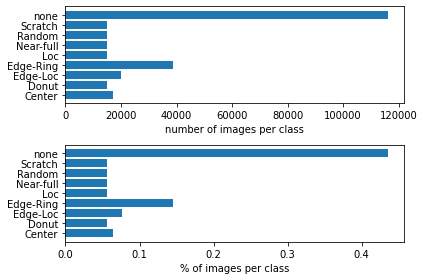

In [ ]:
plt.subplot(2,1,1)
plt.barh(failure_types, types_image_number)
plt.xlabel('number of images per class')

plt.subplot(2,1,2)
plt.barh(failure_types, types_image_proportion)
plt.xlabel('% of images per class')

plt.tight_layout()

In [ ]:
number_failure_images = sum(types_image_number[:8])
number_ok_images = types_image_number[8]

[number_failure_images,number_ok_images]

[150925, 116022]

<BarContainer object of 2 artists>

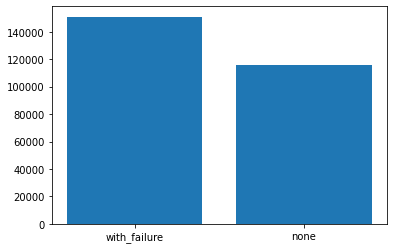

In [ ]:
plt.bar(['with_failure','none'],[number_failure_images,number_ok_images])

#Performance evaluation

We define some functions by hand for a more detailed verification of the network performance.

We first define a validation-set conversion function from BatchDataset to list (where each element is a tensor representing a batch). This way, we can manage the order of the batches without shuffling them automatically.

In [ ]:
# The function returns a tuple with two lists, one with the batches of the images, 
# the other with the relative batches of the ground_truth.

def from_DataBatch_to_list(dataBatch):
  val_dataset2 = [] 
  val_dataset2_gt = []
  i=0

  for batch in dataBatch:
    for i in range(len(batch)):
      if (i==0):
        val_dataset2.append(batch[i])
      if(i==1):
        val_dataset2_gt.append(batch[i])
    
  return (val_dataset2, val_dataset2_gt)

We now define a function that allows to calculate the Top-k accuracy.

In [ ]:
# Input: tuple with 2 lists, obtained from the from_DataBatch_to_list function

def topk_accuracy(model, k, validationTuple):
  val_dataset = validationTuple[0]
  val_dataset_gt = validationTuple[1]

  # TopK accuracy metric
  m = keras.metrics.TopKCategoricalAccuracy( 
        k=k, 
        name='top_k_categorical_accuracy', 
        dtype=None
      )

  # We iterate over the individual batches
  for i in range(len(val_dataset)):
    prediction = model.predict(val_dataset[i])
    # Let's convert prediction in a tensor
    prediction = tf.convert_to_tensor(prediction)
    # Now we update the metric with respect to the current batch 
    m.update_state(val_dataset_gt[i], prediction)
  
  return m.result().numpy()

We now define a function for the computation of the confusion matrix.

A list of thresholds can be passed to the function. In this case, for each threshold, the function returns the confusion matrix in which an input image is classified as a certain error class C only if the greater probability (among those associated with classes other than none) is the one associated with C and exceeds the threshold. Otherwise, the none class is assigned to the image.

On the other hand, if the list of thresholds is empty, the classification of the images occurs simply by associating the class with the highest probability.

In [ ]:
def confusion_matrix(model, failure_types, validationTuple, threshold):
  precision = []
  recall = []

  val_dataset = validationTuple[0]
  val_dataset_gt = validationTuple[1]

  if (len(threshold)!=0):
    # We determine the predicted class for each data in the validation-set and build 
    # the corresponding list containing the ground truth
    for i in range(len(val_dataset)): 
      if i == 0:
        prediction = model.predict(val_dataset[i])
        prediction_gt = list(map(lambda x: np.asarray(x).argmax(), val_dataset_gt[i]))
        # We determine the predicted class
        predicted_class = list(map(lambda x: x[:8].argmax(), prediction))
        # We store the probability value for the predicted class
        predicted_class_probability = list(map(lambda x: x[:8].max(), prediction))

      prediction = model.predict(val_dataset[i])
      prediction_gt.extend(list(map(lambda x: np.asarray(x).argmax(), val_dataset_gt[i])))
      # We determine the predicted class
      predicted_class.extend(list(map(lambda x: x[:8].argmax(), prediction)))
      # We store the probability value for the predicted class
      predicted_class_probability.extend(list(map(lambda x: x[:8].max(), prediction)))

    # We calculate the confusion matrix for each threshold
    cm = []
    for l in range(len(threshold)):
      cm.append([[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0]])

      for i in range(len(failure_types)):
        for j in range(len(prediction_gt)):
          if (prediction_gt[j] == i):
            # If the predicted value does not exceed the threshold we classify the item as a negative class
            if (predicted_class_probability[j]<=threshold[l]):
                  cm[l][i][8] += 1
            else:
              for k in range(len(failure_types)):
                if (predicted_class[j] == k):
                  cm[l][i][k] += 1

    return cm

  else:
    # We determine the predicted class for each data in the validation-set and build 
    # the corresponding list containing the ground truth
    for i in range(len(val_dataset)):
      if i == 0:
        prediction = model.predict(val_dataset[i])
        prediction_gt = list(map(lambda x: np.asarray(x).argmax(), val_dataset_gt[i]))
        # We determine the predicted class
        predicted_class = list(map(lambda x: x.argmax(), prediction))

      prediction = model.predict(val_dataset[i])
      prediction_gt.extend(list(map(lambda x: np.asarray(x).argmax(), val_dataset_gt[i])))
      # We determine the predicted class
      predicted_class.extend(list(map(lambda x: x.argmax(), prediction)))

    # We calculate the confusion matrix for each threshold
    cm = [[0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0],
              [0,0,0,0,0,0,0,0,0]]

    for i in range(len(failure_types)):
      for j in range(len(prediction_gt)):
        if (prediction_gt[j] == i):
          for k in range(len(failure_types)):
            if (predicted_class[j] == k):
              cm[i][k] += 1

    return cm

We now define a function that allows us to calculate the proportion of correctly recognized images for each class.

In [ ]:
def classes_proportion_correctly_classified(c_matrix, failure_types):
  dict_ = {}
  for i in range(len(failure_types)):
    dict_[failure_types[i]] = c_matrix[i][i]/np.sum(c_matrix[i])
  
  return dict_

We now define a function that, given the confusion matrix as input, calculates the values ​​of accuracy, recall and F1-measure for a given model.

Since the problem is multi-class, the precision and recall values ​​are calculated considering the class without defects (none) as negative and the remaining 8 classes of defective images as positive. In particular, given TPi the number of images correctly classified (i.e. as belonging to class i) by a generic model and:

- 0: Center;
- 1: Donut;
- 2: Edge-Loc;
- 3: Edge-Ring;
- 4: Loc;
- 5: Near-full;
- 6: Random;
- 7: Scratch.

The value of TP has been defined as:

- TP = TP1 + TP2 + TP3 + TP4 + TP5 + TP6 + TP7,

that is the sum of the images correctly classified for each class.

Basically, in the calculation of precision and recall, the images correctly classified as defective but associated with an incorrect defect class were not considered. Therefore from the confusion matrix only the values ​​of the main diagonal, those of the last row and those of the last column are used.

In [ ]:
def metrics_report(c_matrix):
  precision = 0
  recall = 0

  num = 0
  precision_den = 0
  recall_den = 0

  for i in range(len(c_matrix)):
  # Index 8 is assumed to represent the negative class
    if (i != 8):
      num += c_matrix[i][i]
      precision_den += c_matrix[i][i] + c_matrix[8][i]
      recall_den += c_matrix[i][i] + c_matrix[i][8]
    

  precision = num/precision_den
  recall = num/recall_den
  return (
      {'precision': precision, 
       'recall': recall,
       'f1-measure': 2*(precision*recall)/(precision+recall)})

We now define a function that allows to plot the ROC curves.

In [ ]:
def roc_auc_report(confusion_matrixes):
  tp_rates = []
  fp_rates = []

  for l in range(len(confusion_matrixes)):
    tp = 0; fn = 0
    fp = 0; tn = 0

    cm = confusion_matrixes[l]

    for i in range(len(cm)):
      if (i != 8):
        tp += cm[i][i] 
        fn += cm[i][8]
        fp += cm[8][i]
      
      if (i == 8):
        tn = cm[i][i]
  
    tp_rates.append(tp/(tp+fn))
    fp_rates.append(fp/(fp+tn))

  return (tp_rates, fp_rates)

In [ ]:
def roc_curve(tp_rates, fp_rates):
  tp = copy.deepcopy(tp_rates)
  #tp.extend([0])
  tp.reverse()

  fp = copy.deepcopy(fp_rates)
  #fp.extend([0])
  fp.reverse()

  plt.plot(fp, tp)
  plt.plot([0, 1], ls="--")
  plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
  plt.xlabel("false positive rate") 
  plt.ylabel("true positive rate")
  plt.title("ROC curve")

In [ ]:
threshold1 = np.arange(0, 1, 0.01).tolist()
threshold2 = []

# Model 0: base


Now, let's take care of the **model selection**. On the basis of the available data, we will therefore look for the best combination of parameters, able to guarantee the lowest loss and the greatest stability on the **validation-set**.

Based on the validation-set, for each model we calculate:

* Val_loss vs train_loss chart.
* Val_accuracy vs train_accuracy chart.
* Top-1 accuracy.
* Top-3 accuracy.
* Top-5 accuracy.
* Precision.
* Recall.
* F-measure.
* ROC curves.

## Loading data

Let's load the data from the JSON into the folders.

In [ ]:
with open('/content/gdrive/MyDrive/DeepLearning/WM811K_train_padded_resized_not_augmented.json', 'r') as f:
  data = json.load(f)

In [ ]:
cols = data['columns']
cols

['waferMap', 'failureType']

In [ ]:
dict_ = dict()

for col in cols:
  dict_[col] = list()

for i in range(len(cols)):
  for j in range(len(data['data'])):
    if i == 0:
      dict_[cols[i]].append(data['data'][j][i])
    elif i == 1:
      dict_[cols[i]].append(data['data'][j][i])
      
data = pd.DataFrame(dict_)

In [ ]:
classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]
training = [0] * 9

for i in range(len(training)):
  training[i] = data[data['failureType'] == classes[i]]
  training[i] = training[i].reset_index(drop = True)
  
print(sum(len(i) for i in training))

136196


Now let's extract the validation-set, so that we can use it to compare trained models on augmented and non-augmented data.

In [ ]:
validation = []

for i in range(len(training)):
  validation.append(training[i].sample(frac = 0.2))
  training[i].drop(validation[i].index, inplace=True)

In [ ]:
print(sum(len(i) for i in training), sum(len(i) for i in validation))

108956 27240


Let's now create folders at runtime that contain the two datasets, so that images of the same class are contained in the same folder.

In [ ]:
!rm -rf WM811K_train
!rm -rf WM811K_val

In [ ]:
!mkdir WM811K_train
!mkdir WM811K_val

In [ ]:
path1 = "/content/WM811K_train/"
path2 = "/content/WM811K_val/"

for i in classes:
  os.mkdir(path1+i)
  os.mkdir(path2+i)

### Training

In [ ]:
for i in range(len(classes)):
  for j in range(len(training[i])):
    if(j%1000 == 0):
      print('/content/WM811K_train/'+classes[i]+'/'+str(j)+'.png')
    matplotlib.image.imsave('/content/WM811K_train/'+classes[i]+'/'+str(j)+'.png', training[i]['waferMap'].iloc[j])

/content/WM811K_train/Center/0.png
/content/WM811K_train/Center/1000.png
/content/WM811K_train/Center/2000.png
/content/WM811K_train/Donut/0.png
/content/WM811K_train/Edge-Loc/0.png
/content/WM811K_train/Edge-Loc/1000.png
/content/WM811K_train/Edge-Loc/2000.png
/content/WM811K_train/Edge-Loc/3000.png
/content/WM811K_train/Edge-Ring/0.png
/content/WM811K_train/Edge-Ring/1000.png
/content/WM811K_train/Edge-Ring/2000.png
/content/WM811K_train/Edge-Ring/3000.png
/content/WM811K_train/Edge-Ring/4000.png
/content/WM811K_train/Edge-Ring/5000.png
/content/WM811K_train/Edge-Ring/6000.png
/content/WM811K_train/Loc/0.png
/content/WM811K_train/Loc/1000.png
/content/WM811K_train/Loc/2000.png
/content/WM811K_train/Near-full/0.png
/content/WM811K_train/Random/0.png
/content/WM811K_train/Scratch/0.png
/content/WM811K_train/none/0.png
/content/WM811K_train/none/1000.png
/content/WM811K_train/none/2000.png
/content/WM811K_train/none/3000.png
/content/WM811K_train/none/4000.png
/content/WM811K_train/none

### Validation

In [ ]:
validation = validation_set

In [ ]:
for i in range(len(classes)):
  for j in range(len(validation[i])):
    if(j%1000 == 0):
      print('/content/WM811K_val/'+classes[i]+'/'+str(j)+'.png')
    matplotlib.image.imsave('/content/WM811K_val/'+classes[i]+'/'+str(j)+'.png', validation[i]['waferMap'].iloc[j])

/content/WM811K_val/Center/0.png
/content/WM811K_val/Donut/0.png
/content/WM811K_val/Edge-Loc/0.png
/content/WM811K_val/Edge-Ring/0.png
/content/WM811K_val/Edge-Ring/1000.png
/content/WM811K_val/Loc/0.png
/content/WM811K_val/Near-full/0.png
/content/WM811K_val/Random/0.png
/content/WM811K_val/Scratch/0.png
/content/WM811K_val/none/0.png
/content/WM811K_val/none/1000.png
/content/WM811K_val/none/2000.png
/content/WM811K_val/none/3000.png
/content/WM811K_val/none/4000.png
/content/WM811K_val/none/5000.png
/content/WM811K_val/none/6000.png
/content/WM811K_val/none/7000.png
/content/WM811K_val/none/8000.png


Let's save the validation-set on Drive as JSON.

In [ ]:
validation_preprocessed = pd.concat([validation[0],validation[1],validation[2],
                        validation[3],validation[4],validation[5],
                        validation[6],validation[7],validation[8]])

validation_preprocessed['failureType'] = list(map(lambda x: str(x), validation_preprocessed['failureType']))

parsed = json.loads(validation_preprocessed.to_json(orient = "split"))

with open('/content/gdrive/MyDrive/DeepLearning/Marco/Validation.json','w') as f:
    json.dump(parsed, f)
del parsed

### Test

In [ ]:
with open('/content/gdrive/MyDrive/DeepLearning/WM811K_test_padded_resized_not_augmented.json', 'r') as f:
  data = json.load(f)

In [ ]:
cols = data['columns']
cols

['waferMap', 'failureType']

In [ ]:
dict_ = dict()

for col in cols:
  dict_[col] = list()

for i in range(len(cols)):
  for j in range(len(data['data'])):
    if i == 0:
      dict_[cols[i]].append(data['data'][j][i])
    elif i == 1:
      dict_[cols[i]].append(data['data'][j][i])
      
data = pd.DataFrame(dict_)

In [ ]:
classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]
test = [0] * 9

for i in range(len(test)):
  test[i] = data[data['failureType'] == classes[i]]
  test[i] = test[i].reset_index(drop = True)
  
print(sum(len(i) for i in test))

34050


In [ ]:
!rm -rf WM811K_test

In [ ]:
!mkdir WM811K_test

In [ ]:
path = "/content/WM811K_test/"
for i in classes:
  os.mkdir(path+i)

In [ ]:
for i in range(len(classes)):
  for j in range(len(test[i])):
    if(j%1000 == 0):
      print('/content/WM811K_test/'+classes[i]+'/'+str(j)+'.png')
    matplotlib.image.imsave('/content/WM811K_test/'+classes[i]+'/'+str(j)+'.png', test[i]['waferMap'].iloc[j])

/content/WM811K_test/Center/0.png
/content/WM811K_test/Donut/0.png
/content/WM811K_test/Edge-Loc/0.png
/content/WM811K_test/Edge-Loc/1000.png
/content/WM811K_test/Edge-Ring/0.png
/content/WM811K_test/Edge-Ring/1000.png
/content/WM811K_test/Loc/0.png
/content/WM811K_test/Near-full/0.png
/content/WM811K_test/Random/0.png
/content/WM811K_test/Scratch/0.png
/content/WM811K_test/none/0.png
/content/WM811K_test/none/1000.png
/content/WM811K_test/none/2000.png
/content/WM811K_test/none/3000.png
/content/WM811K_test/none/4000.png
/content/WM811K_test/none/5000.png
/content/WM811K_test/none/6000.png
/content/WM811K_test/none/7000.png
/content/WM811K_test/none/8000.png
/content/WM811K_test/none/9000.png
/content/WM811K_test/none/10000.png
/content/WM811K_test/none/11000.png
/content/WM811K_test/none/12000.png
/content/WM811K_test/none/13000.png
/content/WM811K_test/none/14000.png
/content/WM811K_test/none/15000.png
/content/WM811K_test/none/16000.png
/content/WM811K_test/none/17000.png
/content/

### Training augmented

In [ ]:
with open('/content/gdrive/MyDrive/DeepLearning/WM811K_final_train.json', 'r') as f:
  data_aug = json.load(f)

In [ ]:
cols = data_aug['columns']
cols

['waferMap', 'failureType']

In [ ]:
dict_ = dict()

for col in cols:
  dict_[col] = list()

for i in range(len(cols)):
  for j in range(len(data_aug['data'])):
    if i == 0:
      dict_[cols[i]].append(data_aug['data'][j][i])
    elif i == 1:
      dict_[cols[i]].append(data_aug['data'][j][i])

data_aug = pd.DataFrame(dict_)

In [ ]:
len(data_aug)

266947

In [ ]:
classes = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]
training_aug = [0] * 9

for i in range(len(training_aug)):
  training_aug[i] = data_aug[data_aug['failureType'] == classes[i]]
  print(len(training_aug[i]))
  training_aug[i] = training_aug[i].reset_index(drop = True)

17115
15000
20170
38640
15000
15000
15000
15000
116022


Let's now read the validation-set in order to remove it from the training augmented set.

In [ ]:
with open('/content/gdrive/MyDrive/DeepLearning/Marco/Validation.json', 'r') as f:
  validation = json.load(f)

In [ ]:
dict_ = dict()

for col in cols:
  dict_[col] = list()

for i in range(len(cols)):
  for j in range(len(validation['data'])):
    if i == 0:
      dict_[cols[i]].append(validation['data'][j][i])
    elif i == 1:
      dict_[cols[i]].append(validation['data'][j][i])

validation = pd.DataFrame(dict_)

In [ ]:
validation_set = [0] * 9

for i in range(len(validation_set)):
  validation_set[i] = validation[validation['failureType'] == classes[i]]
  print(len(validation_set[i]))
  validation_set[i] = validation_set[i].reset_index(drop = True)

685
89
807
1546
562
24
138
185
23204


We increase the validation-set so that we can also remove the augmented images from training.

In [ ]:
for i in range(len(validation_set) - 1):
  for j in range(len(validation_set[i]['waferMap'])):
    img = copy.deepcopy(Image.fromarray(np.array(validation_set[i]['waferMap'][j], dtype = np.uint8)))
    horiz_img = img.transpose(method = Image.FLIP_LEFT_RIGHT)
    vert_img = img.transpose(method = Image.FLIP_TOP_BOTTOM)
    rotated_img_1 = img.transpose(method = Image.ROTATE_90)
    rotated_img_2 = img.transpose(method = Image.ROTATE_270)
    validation_set[i].loc[validation_set[i].shape[0]] = [horiz_img, classes[i]]
    validation_set[i].loc[validation_set[i].shape[0]] = [vert_img, classes[i]]
    validation_set[i].loc[validation_set[i].shape[0]] = [rotated_img_1, classes[i]]
    validation_set[i].loc[validation_set[i].shape[0]] = [rotated_img_2, classes[i]]

In [ ]:
for i in range(len(validation_set)):
  for j in range(len(validation_set[i]['waferMap'])):
    validation_set[i]['waferMap'][j] = np.array(validation_set[i]['waferMap'][j]).tolist()

Let's convert the representation of matrices from lists to tuples.

In [ ]:
def to_hashable(lista):
  for i in range(len(lista)):
    lista[i] = tuple(lista[i])
  
  return lista

In [ ]:
for i in range(len(training_aug)):
  new_col1 = list(map(lambda x: to_hashable(x), training_aug[i]['waferMap']))
  new_col1 = list(map(lambda x: tuple(x), new_col1))

  new_col2 = list(map(lambda x: to_hashable(x), validation_set[i]['waferMap']))
  new_col2 = list(map(lambda x: tuple(x), new_col2))

  training_aug[i]['waferMap'] = new_col1
  validation_set[i]['waferMap'] = new_col2

  del new_col1
  del new_col2

We remove the validation-set from the training augmented set.

In [ ]:
for i in range(len(training_aug)):
  training_aug[i] = pd.merge(training_aug[i], validation_set[i], indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

In [ ]:
for i in range(len(training_aug)):
  print(len(training_aug[i]))

13675
14555
16088
30835
12160
14870
14305
14060
92173


In [ ]:
!rm -rf WM811K_train_aug

In [ ]:
!mkdir WM811K_train_aug

In [ ]:
path = "/content/WM811K_train_aug/"
for i in classes:
  os.mkdir(path+i)

In [ ]:
for i in range(len(classes)):
  for j in range(len(training_aug[i])):
    if(j%1000 == 0):
      print('/content/WM811K_train_aug/'+classes[i]+'/'+str(j)+'.png')
    matplotlib.image.imsave('/content/WM811K_train_aug/'+classes[i]+'/'+str(j)+'.png', training_aug[i]['waferMap'].iloc[j])

/content/WM811K_train_aug/Center/0.png
/content/WM811K_train_aug/Center/1000.png
/content/WM811K_train_aug/Center/2000.png
/content/WM811K_train_aug/Center/3000.png
/content/WM811K_train_aug/Center/4000.png
/content/WM811K_train_aug/Center/5000.png
/content/WM811K_train_aug/Center/6000.png
/content/WM811K_train_aug/Center/7000.png
/content/WM811K_train_aug/Center/8000.png
/content/WM811K_train_aug/Center/9000.png
/content/WM811K_train_aug/Center/10000.png
/content/WM811K_train_aug/Center/11000.png
/content/WM811K_train_aug/Center/12000.png
/content/WM811K_train_aug/Center/13000.png
/content/WM811K_train_aug/Donut/0.png
/content/WM811K_train_aug/Donut/1000.png
/content/WM811K_train_aug/Donut/2000.png
/content/WM811K_train_aug/Donut/3000.png
/content/WM811K_train_aug/Donut/4000.png
/content/WM811K_train_aug/Donut/5000.png
/content/WM811K_train_aug/Donut/6000.png
/content/WM811K_train_aug/Donut/7000.png
/content/WM811K_train_aug/Donut/8000.png
/content/WM811K_train_aug/Donut/9000.png
/con

Let's take the data from the folders.

In [ ]:
train_path = '/content/WM811K_train'
train_dataset = keras.preprocessing.image_dataset_from_directory(train_path,
                                                            image_size = (53, 52),
                                                            color_mode = 'rgb',
                                                            batch_size = 32,
                                                            label_mode = 'categorical',
                                                            shuffle = True,
                                                            seed = 1)

val_path = '/content/WM811K_val'
val_dataset = keras.preprocessing.image_dataset_from_directory(val_path,
                                                            image_size = (53, 52),
                                                            color_mode = 'rgb',
                                                            batch_size = 32,
                                                            label_mode = 'categorical',
                                                            shuffle = True,
                                                            seed = 1)

test_path = '/content/WM811K_test'
test_dataset = keras.preprocessing.image_dataset_from_directory(test_path,
                                                            image_size = (53, 52),
                                                            color_mode = 'rgb',
                                                            batch_size = 32,
                                                            label_mode = 'categorical',
                                                            shuffle = True,
                                                            seed = 1)

train_aug_path = '/content/WM811K_train_aug'
train_aug_dataset = keras.preprocessing.image_dataset_from_directory(train_aug_path,
                                                            image_size = (53, 52),
                                                            color_mode = 'rgb',
                                                            batch_size = 32,
                                                            label_mode = 'categorical',
                                                            shuffle = True,
                                                            seed = 1)

Found 108272 files belonging to 9 classes.
Found 27240 files belonging to 9 classes.
Found 34050 files belonging to 9 classes.
Found 222721 files belonging to 9 classes.


Let's save the validation-set as tf.dataset on Drive. We will need it later for the detailed performance evaluation.

In [ ]:
tf.data.experimental.save(val_dataset, "/content/gdrive/MyDrive/DeepLearning/Marco/Val")

In [ ]:
val_dataset = tf.data.experimental.load("/content/gdrive/MyDrive/DeepLearning/Marco/Val")
val_tuple = from_DataBatch_to_list(val_dataset)

## Vanilla data

### Network definition

We test a basic model with the data obtained before augmentation.
The basic model consists of **3 convolutional layers** (**32, 64 and 128 filters**, **kernel_size = 3**, **padding = same**), **3 pooling layers** (**3x3 pooling window**, **padding = same**) and **1 layer dense** (**9 units**). The activation functions related to the convolutional layers are **ReLU**, while ** Softmax ** has been chosen for the Dense layer. The model is then compiled with **Adam** optimizer (**learning-rate = 0.001**) and the training performed with **20 epochs**.

In [ ]:
num_classes = 9
inputs = keras.Input((53, 52, 3)) 

x = keras.layers.Conv2D(32, 3, padding = 'same')(inputs) 
x = keras.layers.Activation('relu')(x) 
x = keras.layers.MaxPooling2D(3, padding = "same")(x) 
x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, padding = "same")(x) 
x = keras.layers.Conv2D(128, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.GlobalMaxPool2D()(x) 

outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model0 = keras.Model(inputs, outputs)

In [ ]:
model0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 53, 52, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 53, 52, 32)        896       
                                                                 
 activation (Activation)     (None, 53, 52, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 18, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 18, 18, 64)        0         
                                                             

In [ ]:
model0.compile(loss = keras.losses.categorical_crossentropy,
               optimizer = keras.optimizers.Adam(learning_rate = 0.001),
               metrics = ['accuracy'])

### Fitting

In [ ]:
history0 = model0.fit(train_dataset, epochs = 20, validation_data = val_dataset)

Epoch 1/20
3384/3384 [==============================] - 400s 118ms/step - loss: 0.3437 - accuracy: 0.9445 - val_loss: 0.1446 - val_accuracy: 0.9598
Epoch 2/20
3384/3384 [==============================] - 393s 116ms/step - loss: 0.1411 - accuracy: 0.9609 - val_loss: 0.1309 - val_accuracy: 0.9612
Epoch 3/20
3384/3384 [==============================] - 382s 113ms/step - loss: 0.1286 - accuracy: 0.9634 - val_loss: 0.1160 - val_accuracy: 0.9656
Epoch 4/20
3384/3384 [==============================] - 356s 105ms/step - loss: 0.1211 - accuracy: 0.9652 - val_loss: 0.1252 - val_accuracy: 0.9635
Epoch 5/20
3384/3384 [==============================] - 364s 108ms/step - loss: 0.1100 - accuracy: 0.9680 - val_loss: 0.1155 - val_accuracy: 0.9670
Epoch 6/20
3384/3384 [==============================] - 357s 105ms/step - loss: 0.1066 - accuracy: 0.9687 - val_loss: 0.1190 - val_accuracy: 0.9652
Epoch 7/20
3384/3384 [==============================] - 360s 106ms/step - loss: 0.1018 - accuracy: 0.9710 - val_

### Model analysis

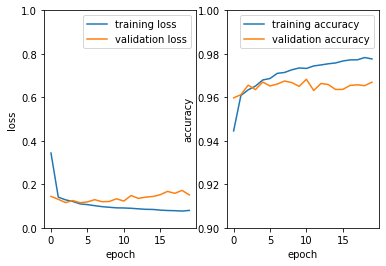

In [ ]:
plt.subplot(1,2,1)
plt.plot(history0.history['loss'])
plt.plot(history0.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history0.history['accuracy'])
plt.plot(history0.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.9, 1])
plt.legend(['training accuracy', 'validation accuracy'])

From the loss curves we can see how the model overfits starting from about the fifth epoch. Accuracy after slight initial growth also fails to improve.

In [ ]:
print(topk_accuracy(model0, 1, val_tuple))
print(topk_accuracy(model0, 3, val_tuple))
print(topk_accuracy(model0, 5, val_tuple))

0.9669604
0.995815
0.99937594


Overall, the top-1 accuracy is high (about 96.7%), even if this result is probably very influenced by the imbalance problem between the classes.

The top-3 accuracy is almost maximum.

In [ ]:
failure_types = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]

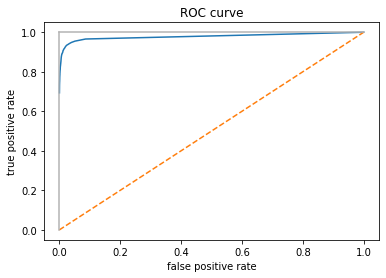

In [ ]:
cm1 = confusion_matrix(model0, failure_types, val_tuple, threshold1)
rates = roc_auc_report(cm1)
roc_curve(rates[0], rates[1])

In [ ]:
cm2 = confusion_matrix(model0, failure_types, val_tuple, threshold2)
metrics_report(cm2)

{'f1-measure': 0.9166782584504103,
 'precision': 0.9550724637681159,
 'recall': 0.8812516715699384}

As can be seen, the precision is high and approximately equal to the accuracy, but the recall is 7% lower.

In [ ]:
p = classes_proportion_correctly_classified(cm2, failure_types)

In [ ]:
p

{'Center': 0.8861313868613139,
 'Donut': 0.797752808988764,
 'Edge-Loc': 0.6646039603960396,
 'Edge-Ring': 0.9793148028442146,
 'Loc': 0.6660746003552398,
 'Near-full': 0.7916666666666666,
 'Random': 0.8478260869565217,
 'Scratch': 0.2903225806451613,
 'none': 0.9933281680440771}

What was said previously is confirmed by the fact that the images of the *none* class are recognized 99.3% of the time, while some defect classes do not reach 70%. The *scratch* class is the one that suffers from the lowest percentage of correct grading.

In [ ]:
np.mean(list(p.values()))

0.7685578957508887

Overall, the average of the classification percentages on the individual classes is about 20% less than the top-1 accuracy.

Based on what we have observed, we train the same model but with **increased data**.

### Save

Let's save the model.

In [ ]:
model0.save('/content/gdrive/MyDrive/DeepLearning/Models/model0')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/DeepLearning/Models/model0/assets


## Augmented data

### Network definition

In [ ]:
num_classes = 9
inputs = keras.Input((53, 52, 3)) 

x = keras.layers.Conv2D(32, 3, padding = 'same')(inputs) 
x = keras.layers.Activation('relu')(x) 
x = keras.layers.MaxPooling2D(3, padding = "same")(x) 
x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, padding = "same")(x) 
x = keras.layers.Conv2D(128, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.GlobalMaxPool2D()(x) 

outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model0_1 = keras.Model(inputs, outputs)

In [ ]:
model0_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 53, 52, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 53, 52, 32)        896       
                                                                 
 activation_3 (Activation)   (None, 53, 52, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 activation_4 (Activation)   (None, 18, 18, 64)        0         
                                                           

In [ ]:
model0_1.compile(loss = keras.losses.categorical_crossentropy,
                 optimizer = keras.optimizers.Adam(learning_rate = 0.001),
                 metrics = ['accuracy'])

### Fitting

In [ ]:
history0_1 = model0_1.fit(train_aug_dataset, epochs = 20, validation_data = val_dataset)

Epoch 1/20
6961/6961 [==============================] - 134s 19ms/step - loss: 0.3086 - accuracy: 0.9197 - val_loss: 0.1570 - val_accuracy: 0.9525
Epoch 2/20
6961/6961 [==============================] - 100s 14ms/step - loss: 0.1774 - accuracy: 0.9424 - val_loss: 0.1325 - val_accuracy: 0.9647
Epoch 3/20
6961/6961 [==============================] - 101s 15ms/step - loss: 0.1533 - accuracy: 0.9495 - val_loss: 0.1181 - val_accuracy: 0.9649
Epoch 4/20
6961/6961 [==============================] - 102s 15ms/step - loss: 0.1434 - accuracy: 0.9529 - val_loss: 0.1266 - val_accuracy: 0.9625
Epoch 5/20
6961/6961 [==============================] - 100s 14ms/step - loss: 0.1373 - accuracy: 0.9549 - val_loss: 0.1150 - val_accuracy: 0.9645
Epoch 6/20
6961/6961 [==============================] - 104s 15ms/step - loss: 0.1320 - accuracy: 0.9564 - val_loss: 0.1203 - val_accuracy: 0.9649
Epoch 7/20
6961/6961 [==============================] - 101s 14ms/step - loss: 0.1303 - accuracy: 0.9576 - val_loss: 0

### Model analysis

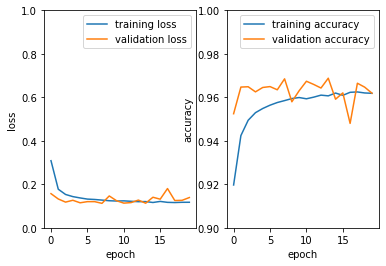

In [ ]:
plt.subplot(1,2,1)
plt.plot(history0_1.history['loss'])
plt.plot(history0_1.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history0_1.history['accuracy'])
plt.plot(history0_1.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.9, 1])
plt.legend(['training accuracy', 'validation accuracy'])

Compared to model 0, we observe less overfitting, but also a worsening of performance on the training set:

- about +0.03 on the loss;
- approximately -1.6% accuracy.

Furthermore, convergence is not particularly stable.

In [ ]:
print(topk_accuracy(model0_1, 1, val_tuple))
print(topk_accuracy(model0_1, 3, val_tuple))
print(topk_accuracy(model0_1, 5, val_tuple))

0.9618943
0.99720997
0.99977976


The top1 accuracy decreased by about 0.6%.

In [ ]:
failure_types = ["Center", "Donut", "Edge-Loc", "Edge-Ring", "Loc", "Near-full", "Random", "Scratch", "none"]

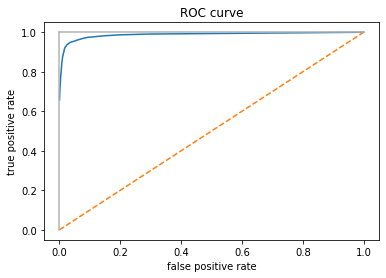

In [ ]:
cm1 = confusion_matrix(model0_1, failure_types, val_tuple, threshold1)
rates = roc_auc_report(cm1)
roc_curve(rates[0], rates[1])

In [ ]:
cm2 = confusion_matrix(model0_1, failure_types, val_tuple, threshold2)
metrics_report(cm2)

{'f1-measure': 0.902457956015524,
 'precision': 0.8777050830397585,
 'recall': 0.9286474973375932}

It is observed that the model has a lower precision of about 9% of the accuracy while the recall is lower of about 6%.

In [ ]:
p = classes_proportion_correctly_classified(cm2, failure_types)

{'Center': 0.910948905109489,
 'Donut': 0.7640449438202247,
 'Edge-Loc': 0.7970297029702971,
 'Edge-Ring': 0.9819004524886877,
 'Loc': 0.7495559502664298,
 'Near-full': 1.0,
 'Random': 0.8260869565217391,
 'Scratch': 0.3924731182795699,
 'none': 0.9790805785123967}

We notice an improvement compared to model 0 regarding the classes:

- Center
- Edge-Loc
- Edge-Ring
- Loc
- Scratch
- Near full

The mean value is:

In [ ]:
np.mean(list(p.values()))

0.8223467342187595

The mean of the percentages on the single classes increased by about 5%, although on the *none* class it decreased by about 1.3%. This proves that augmentation has actually improved the classification of the previously less represented classes.

### Save

Let's save the model.

In [ ]:
model0_1.save('/content/gdrive/MyDrive/DeepLearning/Models/model0_1')

We implement an **EarlyStopping** procedure and then we try to further modify the model.

# Model 1: EarlyStopping

### Network definition

In [ ]:
num_classes = 9
inputs = keras.Input((53, 52, 3)) 

x = keras.layers.Conv2D(32, 3, padding = 'same')(inputs) 
x = keras.layers.Activation('relu')(x) 
x = keras.layers.MaxPooling2D(3, padding = "same")(x) 
x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, padding = "same")(x) 
x = keras.layers.Conv2D(128, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.GlobalMaxPool2D()(x) 

outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model1 = keras.Model(inputs, outputs)

In [ ]:
model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 53, 52, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 53, 52, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 53, 52, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 18, 18, 64)        18496     
                                                                 
 activation_7 (Activation)   (None, 18, 18, 64)        0         
                                                           

In [ ]:
model1.compile(loss = keras.losses.categorical_crossentropy,
               optimizer = keras.optimizers.Adam(learning_rate = 0.001),
               metrics = ['accuracy'])

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

### Fitting

In [ ]:
history1 = model1.fit(train_aug_dataset, epochs = 50, validation_data = val_dataset, callbacks = [stop_early])

Epoch 1/50
6961/6961 [==============================] - 76s 9ms/step - loss: 0.3212 - accuracy: 0.9210 - val_loss: 0.1435 - val_accuracy: 0.9578
Epoch 2/50
6961/6961 [==============================] - 63s 9ms/step - loss: 0.1681 - accuracy: 0.9450 - val_loss: 0.1174 - val_accuracy: 0.9642
Epoch 3/50
6961/6961 [==============================] - 61s 9ms/step - loss: 0.1473 - accuracy: 0.9514 - val_loss: 0.2314 - val_accuracy: 0.9336
Epoch 4/50
6961/6961 [==============================] - 63s 9ms/step - loss: 0.1372 - accuracy: 0.9549 - val_loss: 0.1061 - val_accuracy: 0.9696
Epoch 5/50
6961/6961 [==============================] - 62s 9ms/step - loss: 0.1294 - accuracy: 0.9574 - val_loss: 0.1193 - val_accuracy: 0.9670
Epoch 6/50
6961/6961 [==============================] - 60s 9ms/step - loss: 0.1253 - accuracy: 0.9584 - val_loss: 0.1208 - val_accuracy: 0.9646
Epoch 7/50
6961/6961 [==============================] - 61s 9ms/step - loss: 0.1234 - accuracy: 0.9590 - val_loss: 0.1177 - val_ac

## Model analysis

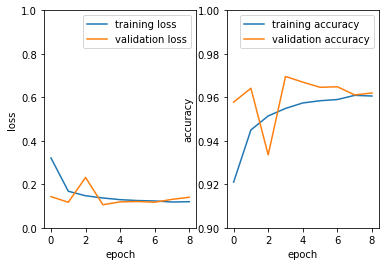

In [ ]:
plt.subplot(1,2,1)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.9, 1])
plt.legend(['training accuracy', 'validation accuracy'])

In [ ]:
print(topk_accuracy(model1, 1, val_tuple))
print(topk_accuracy(model1, 3, val_tuple))
print(topk_accuracy(model1, 5, val_tuple))

0.9620044
0.9969163
0.99974304


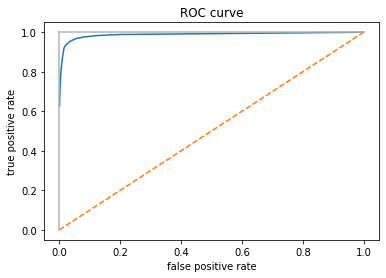

In [ ]:
cm1 = confusion_matrix(model1, failure_types, val_tuple, threshold1)
rates = roc_auc_report(cm1)
roc_curve(rates[0], rates[1])

In [ ]:
cm2 = confusion_matrix(model1, failure_types, val_tuple, threshold2)
metrics_report(cm2)

{'f1-measure': 0.9103264490339773,
 'precision': 0.8928384736016728,
 'recall': 0.9285131829301441}

In [ ]:
prop = classes_proportion_correctly_classified(cm2, failure_types)
prop

{'Center': 0.8935860058309038,
 'Donut': 0.7415730337078652,
 'Edge-Loc': 0.7388613861386139,
 'Edge-Ring': 0.9489334195216548,
 'Loc': 0.8102836879432624,
 'Near-full': 0.8333333333333334,
 'Random': 0.9347826086956522,
 'Scratch': 0.3567567567567568,
 'none': 0.9823511686969997}

In [ ]:
np.mean(list(prop.values()))

0.8044957111805603

We now increase the **complexity** of the model with an extra conv-pool layer, apply the **He-initialization** and decrease the **learning-rate**. We also increase the number of **epochs** and the ** patience ** parameter for a clearer vision of the phenomenon.

## Save

Let's save the model.

In [ ]:
model1.save('/content/gdrive/MyDrive/DeepLearning/Models/model1')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/DeepLearning/Models/model1/assets


# Model 2: Increasing complexity

### Network definition

In [ ]:
num_classes = 9
inputs = keras.Input((53, 52, 3)) 
he_init = tf.keras.initializers.HeNormal()

x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_initializer = he_init)(inputs) 
x = keras.layers.Activation('relu')(x) 
x = keras.layers.MaxPooling2D(3, padding = "same")(x) 
x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_initializer = he_init)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, padding = "same")(x) 
x = keras.layers.Conv2D(128, 3, padding = 'same', kernel_initializer = he_init)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, padding = "same")(x) 
x = keras.layers.Conv2D(256, 3, padding = 'same', kernel_initializer = he_init)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.GlobalMaxPool2D()(x) 

outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model2 = keras.Model(inputs, outputs)

In [ ]:
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 53, 52, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 53, 52, 32)        896       
                                                                 
 activation_9 (Activation)   (None, 53, 52, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 18, 18, 64)        18496     
                                                                 
 activation_10 (Activation)  (None, 18, 18, 64)        0         
                                                           

In [ ]:
model2.compile(loss = keras.losses.categorical_crossentropy,
               optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
               metrics = ['accuracy'])

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

### Fitting

In [ ]:
history2 = model2.fit(train_aug_dataset, epochs = 100, validation_data = val_dataset, callbacks = [stop_early])

Epoch 1/100
6961/6961 [==============================] - 61s 9ms/step - loss: 3.2071 - accuracy: 0.8608 - val_loss: 0.6773 - val_accuracy: 0.8766
Epoch 2/100
6961/6961 [==============================] - 57s 8ms/step - loss: 0.4414 - accuracy: 0.9099 - val_loss: 0.3140 - val_accuracy: 0.9187
Epoch 3/100
6961/6961 [==============================] - 68s 10ms/step - loss: 0.2521 - accuracy: 0.9301 - val_loss: 0.2289 - val_accuracy: 0.9414
Epoch 4/100
6961/6961 [==============================] - 59s 9ms/step - loss: 0.1934 - accuracy: 0.9417 - val_loss: 0.1888 - val_accuracy: 0.9494
Epoch 5/100
6961/6961 [==============================] - 62s 9ms/step - loss: 0.1598 - accuracy: 0.9492 - val_loss: 0.2260 - val_accuracy: 0.9403
Epoch 6/100
6961/6961 [==============================] - 61s 9ms/step - loss: 0.1365 - accuracy: 0.9551 - val_loss: 0.1704 - val_accuracy: 0.9541
Epoch 7/100
6961/6961 [==============================] - 65s 9ms/step - loss: 0.1191 - accuracy: 0.9601 - val_loss: 0.1662 

### Model analysis

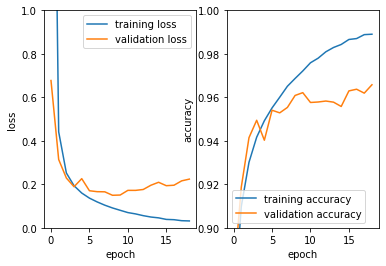

In [ ]:
plt.subplot(1,2,1)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.9, 1])
plt.legend(['training accuracy', 'validation accuracy'])

As expected, the increase in the complexity of the model has led to:

* A clear improvement in training performance (loss was reduced by almost a quarter and accuracy improved by almost 3%).
* An increase in overfitting and a greater loss on validation (approximately 0.08).

In [ ]:
print(topk_accuracy(model2, 1, val_tuple))
print(topk_accuracy(model2, 3, val_tuple))
print(topk_accuracy(model2, 5, val_tuple))

0.9657856
0.9958884
0.99974304


Again, the values of the top-k accuracy, k = 1,3,5, did not change significantly.

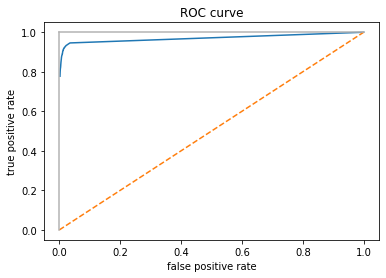

In [ ]:
cm1 = confusion_matrix(model2, failure_types, val_tuple, threshold1)
rates = roc_auc_report(cm1)
roc_curve(rates[0], rates[1])

The ROC shows a worse trend than the previous model.

In [ ]:
cm2 = confusion_matrix(model2, failure_types, val_tuple, threshold2)
metrics_report(cm2)

{'f1-measure': 0.9151622098547577,
 'precision': 0.9273727647867951,
 'recall': 0.9032690246516613}

The f1-measure increased slightly (about 0.47%) as a result of a higher precision (about 3%) and a lower recall (about 2%).

In [ ]:
prop = classes_proportion_correctly_classified(cm2, failure_types)
prop

{'Center': 0.8658892128279884,
 'Donut': 0.7528089887640449,
 'Edge-Loc': 0.7995049504950495,
 'Edge-Ring': 0.9650937297996122,
 'Loc': 0.6808510638297872,
 'Near-full': 0.9583333333333334,
 'Random': 0.8695652173913043,
 'Scratch': 0.23783783783783785,
 'none': 0.9886358744780681}

The *scratch* class has returned to suffer particularly from bad classification, as well as the percentage for the *loc' class has particularly worsened (about 20%).

In [ ]:
np.mean(list(prop.values()))

0.7909466898618918

Overall, the average of the percentages on the individual classes fell by 1% and it's still below the accuracy value.

Now, we remove the added conv-pool layer and build two models based on Model 1. In the first we apply the **BatchNormalization**, in the second we insert a **Dropout** layer.

### Save

Let's save the model.

In [ ]:
model2.save('/content/gdrive/MyDrive/DeepLearning/Models/model2')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/DeepLearning/Models/model2/assets


# Model 3: BatchNormalization

### Network definition

In [ ]:
num_classes = 9
inputs = keras.Input((53, 52, 3)) 
he_init = tf.keras.initializers.HeNormal()

x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_initializer = he_init)(inputs) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)  
x = keras.layers.MaxPooling2D(3, padding = "same")(x) 
x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_initializer = he_init)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, padding = "same")(x) 
x = keras.layers.Conv2D(128, 3, padding = 'same', kernel_initializer = he_init)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.GlobalMaxPool2D()(x) 

outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model3 = keras.Model(inputs, outputs)

In [ ]:
model3.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 53, 52, 3)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 53, 52, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 53, 52, 32)       128       
 ormalization)                                                   
                                                                 
 activation_13 (Activation)  (None, 53, 52, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 18, 18, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 18, 18, 64)        1849

In [ ]:
model3.compile(loss = keras.losses.categorical_crossentropy,
               optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
               metrics = ['accuracy'])

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

### Fitting

In [ ]:
history3 = model3.fit(train_aug_dataset, epochs = 100, validation_data = val_dataset, callbacks = [stop_early])

Epoch 1/100
6961/6961 [==============================] - 58s 8ms/step - loss: 0.2844 - accuracy: 0.9111 - val_loss: 0.1164 - val_accuracy: 0.9659
Epoch 2/100
6961/6961 [==============================] - 57s 8ms/step - loss: 0.1479 - accuracy: 0.9499 - val_loss: 0.1016 - val_accuracy: 0.9687
Epoch 3/100
6961/6961 [==============================] - 57s 8ms/step - loss: 0.1236 - accuracy: 0.9575 - val_loss: 0.0902 - val_accuracy: 0.9713
Epoch 4/100
6961/6961 [==============================] - 59s 9ms/step - loss: 0.1079 - accuracy: 0.9626 - val_loss: 0.0860 - val_accuracy: 0.9725
Epoch 5/100
6961/6961 [==============================] - 63s 9ms/step - loss: 0.0969 - accuracy: 0.9663 - val_loss: 0.0831 - val_accuracy: 0.9728
Epoch 6/100
6961/6961 [==============================] - 66s 10ms/step - loss: 0.0876 - accuracy: 0.9692 - val_loss: 0.0823 - val_accuracy: 0.9731
Epoch 7/100
6961/6961 [==============================] - 61s 9ms/step - loss: 0.0797 - accuracy: 0.9721 - val_loss: 0.0820 

### Model analysis

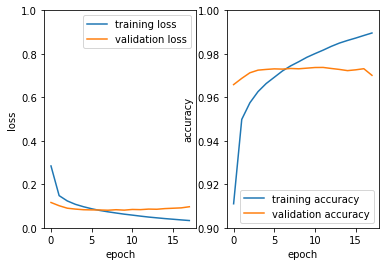

In [ ]:
plt.subplot(1,2,1)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.9, 1])
plt.legend(['training accuracy', 'validation accuracy'])

The accuracy and loss curves relating to the validation-set are much more stable and the loss is very low (0.1164) from the first epoch. In particular:

* Best val_loss: 0.0808 (-0.0253 compared to model 1).
* Best val_accuracy: 97.38% (+ 0.42% compared to model 1).

Despite this, the overfitting phenomenon continues to be observed.

In [ ]:
print(topk_accuracy(model3, 1, val_tuple))
print(topk_accuracy(model3, 3, val_tuple))
print(topk_accuracy(model3, 5, val_tuple))

0.97011745
0.99849486
0.99985313


Compared to the previous model, the top-1 accuracy has improved by about 0.43%.

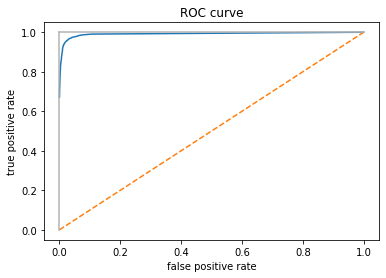

In [ ]:
cm1 = confusion_matrix(model3, failure_types, val_tuple, threshold1)
rates = roc_auc_report(cm1)
roc_curve(rates[0], rates[1])

In [ ]:
cm2 = confusion_matrix(model3, failure_types, val_tuple, threshold2)
metrics_report(cm2)

{'f1-measure': 0.9272490221642763,
 'precision': 0.9150797735460627,
 'recall': 0.9397463002114165}

Recall increased by almost 4%, precision decreased by approximately 1.2% and overall this led to a 1.2% increase in the f1-measure value.

In [ ]:
prop = classes_proportion_correctly_classified(cm2, failure_types)
prop

{'Center': 0.8819241982507289,
 'Donut': 0.9101123595505618,
 'Edge-Loc': 0.8415841584158416,
 'Edge-Ring': 0.9747899159663865,
 'Loc': 0.7872340425531915,
 'Near-full': 0.9583333333333334,
 'Random': 0.8188405797101449,
 'Scratch': 0.5513513513513514,
 'none': 0.9857948430975851}

In [ ]:
np.mean(list(prop.values()))

0.856662753581014

The average of the percentages on the classes also significantly increased by about 6%.

Next, we will introduce **L2 regularization** in order to further reduce overfitting. Let's now insert a **Dropout** layer instead of BatchNormalization.

### Save

Let's save the model.

In [ ]:
model3.save('/content/gdrive/MyDrive/DeepLearning/Models/model3')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/DeepLearning/Models/model3/assets


# Model 4: Dropout

### Network definition

In [ ]:
num_classes = 9
inputs = keras.Input((53, 52, 3)) 
he_init = tf.keras.initializers.HeNormal()

x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_initializer = he_init)(inputs) 
x = keras.layers.Activation('relu')(x) 
x = keras.layers.MaxPooling2D(3, padding = "same")(x) 
x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_initializer = he_init)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, padding = "same")(x) 
x = keras.layers.Conv2D(128, 3, padding = 'same', kernel_initializer = he_init)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.GlobalMaxPool2D()(x) 

x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model4 = keras.Model(inputs, outputs)

In [ ]:
model4.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 53, 52, 3)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 53, 52, 32)        896       
                                                                 
 activation_16 (Activation)  (None, 53, 52, 32)        0         
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 18, 18, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 18, 18, 64)        18496     
                                                                 
 activation_17 (Activation)  (None, 18, 18, 64)        0         
                                                           

In [ ]:
model4.compile(loss = keras.losses.categorical_crossentropy,
               optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
               metrics = ['accuracy'])

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

### Fitting

In [ ]:
history4 = model4.fit(train_aug_dataset, epochs = 100, validation_data = val_dataset, callbacks = [stop_early])

Epoch 1/100
6961/6961 [==============================] - 72s 10ms/step - loss: 7.5242 - accuracy: 0.7001 - val_loss: 0.5581 - val_accuracy: 0.8986
Epoch 2/100
6961/6961 [==============================] - 72s 10ms/step - loss: 0.6994 - accuracy: 0.7989 - val_loss: 0.3469 - val_accuracy: 0.9239
Epoch 3/100
6961/6961 [==============================] - 75s 11ms/step - loss: 0.5073 - accuracy: 0.8476 - val_loss: 0.2365 - val_accuracy: 0.9424
Epoch 4/100
6961/6961 [==============================] - 78s 11ms/step - loss: 0.3833 - accuracy: 0.8814 - val_loss: 0.1956 - val_accuracy: 0.9475
Epoch 5/100
6961/6961 [==============================] - 65s 9ms/step - loss: 0.3281 - accuracy: 0.8962 - val_loss: 0.1819 - val_accuracy: 0.9508
Epoch 6/100
6961/6961 [==============================] - 58s 8ms/step - loss: 0.2961 - accuracy: 0.9060 - val_loss: 0.1662 - val_accuracy: 0.9564
Epoch 7/100
6961/6961 [==============================] - 63s 9ms/step - loss: 0.2759 - accuracy: 0.9120 - val_loss: 0.14

### Model analysis

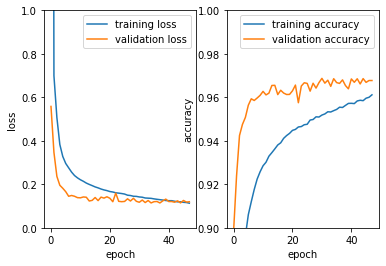

In [ ]:
plt.subplot(1,2,1)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.9, 1])
plt.legend(['training accuracy', 'validation accuracy'])

With the Dropout layer, the two curves are now much closer. However, the loss on the validation set is higher than in model 3 with BatchNormalization. In reality, the two curves are close because the insertion of the Dropout layer does not allow effective training on the training-set itself. In particular:

* Best val_loss: 0.1143 (+0.0335 compared to model 3).
* Best val_accuracy: 96.87% (-0.51% compared to model 3).

In [ ]:
print(topk_accuracy(model4, 1, val_tuple))
print(topk_accuracy(model4, 3, val_tuple))
print(topk_accuracy(model4, 5, val_tuple))

0.9677313
0.99541116
0.9992658


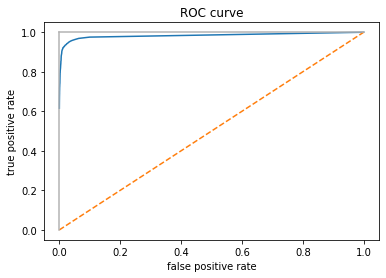

In [ ]:
cm1 = confusion_matrix(model4, failure_types, val_tuple, threshold1)
rates = roc_auc_report(cm1)
roc_curve(rates[0], rates[1])

In [ ]:
cm2 = confusion_matrix(model4, failure_types, val_tuple, threshold2)
metrics_report(cm2)

{'f1-measure': 0.9262754753111748,
 'precision': 0.9379501385041551,
 'recall': 0.9148878681437449}

In [ ]:
prop = classes_proportion_correctly_classified(cm2, failure_types)
prop

{'Center': 0.8688046647230321,
 'Donut': 0.6966292134831461,
 'Edge-Loc': 0.8267326732673267,
 'Edge-Ring': 0.9515190691661279,
 'Loc': 0.7340425531914894,
 'Near-full': 0.875,
 'Random': 0.7318840579710145,
 'Scratch': 0.2810810810810811,
 'none': 0.9903577116783608}

The correct classification percentage for the *scratch* class is even lower than model0 and approximately half of the batch normalization model. The percentage relating to the *donut* class also drops drastically compared to model 3 (about 21%).

In [ ]:
np.mean(list(prop.values()))

0.7728945582846198

Overall, the average on the percentages of the individual classes fell by about 8% compared to the model trained previously.

We use Model 3 as a basis for future evaluations.

## Save

Let's save the model.

In [ ]:
model4.save('/content/gdrive/MyDrive/DeepLearning/Models/model4')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/DeepLearning/Models/model4/assets


# Model 5: L2 regularization

### Network definition

In [ ]:
num_classes = 9
inputs = keras.Input((53, 52, 3)) 
he_init = tf.keras.initializers.HeNormal()

x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_initializer = he_init, kernel_regularizer = tf.keras.regularizers.L2(1e-4))(inputs) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)  
x = keras.layers.MaxPooling2D(3, padding = "same")(x) 
x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_initializer = he_init, kernel_regularizer = tf.keras.regularizers.L2(1e-4))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, padding = "same")(x) 
x = keras.layers.Conv2D(128, 3, padding = 'same', kernel_initializer = he_init, kernel_regularizer = tf.keras.regularizers.L2(1e-4))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.GlobalMaxPool2D()(x) 

outputs = keras.layers.Dense(num_classes, activation = 'softmax', kernel_regularizer = tf.keras.regularizers.L2(1e-4))(x)

model5 = keras.Model(inputs, outputs)

In [ ]:
model5.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 53, 52, 3)]       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 53, 52, 32)        896       
                                                                 
 batch_normalization_3 (Batc  (None, 53, 52, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_19 (Activation)  (None, 53, 52, 32)        0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 18, 18, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 18, 18, 64)        1849

In [ ]:
model5.compile(loss = keras.losses.categorical_crossentropy,
               optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
               metrics = ['accuracy'])

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

### Fitting

In [ ]:
history5 = model5.fit(train_aug_dataset, epochs = 100, validation_data = val_dataset, callbacks = [stop_early])

Epoch 1/100
6961/6961 [==============================] - 61s 9ms/step - loss: 0.3603 - accuracy: 0.9064 - val_loss: 0.1691 - val_accuracy: 0.9636
Epoch 2/100
6961/6961 [==============================] - 61s 9ms/step - loss: 0.1937 - accuracy: 0.9492 - val_loss: 0.1420 - val_accuracy: 0.9696
Epoch 3/100
6961/6961 [==============================] - 59s 8ms/step - loss: 0.1670 - accuracy: 0.9567 - val_loss: 0.1388 - val_accuracy: 0.9703
Epoch 4/100
6961/6961 [==============================] - 58s 8ms/step - loss: 0.1496 - accuracy: 0.9621 - val_loss: 0.1336 - val_accuracy: 0.9713
Epoch 5/100
6961/6961 [==============================] - 57s 8ms/step - loss: 0.1368 - accuracy: 0.9661 - val_loss: 0.1272 - val_accuracy: 0.9718
Epoch 6/100
6961/6961 [==============================] - 58s 8ms/step - loss: 0.1264 - accuracy: 0.9691 - val_loss: 0.1261 - val_accuracy: 0.9715
Epoch 7/100
6961/6961 [==============================] - 58s 8ms/step - loss: 0.1176 - accuracy: 0.9721 - val_loss: 0.1203 -

## Model analysis

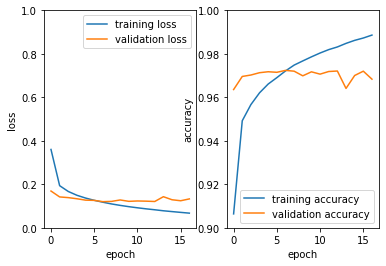

In [ ]:
plt.subplot(1,2,1)
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.9, 1])
plt.legend(['training accuracy', 'validation accuracy'])

Although the relative curve demonstrates a certain stability, the loss on the validation-set has increased by 0.04 compared to model 3. However, this could be due to an incorrect parameter setting. We will then look for the best possible combination of **learning-rate** and **L2-regularization** parameters. In particular:

* Best val_loss: 0.1203 (+0.0395 compared to model 3).
* Best val_accuracy: 97.24% (-0.14% compared to model 3).

In [ ]:
print(topk_accuracy(model5, 1, val_tuple))
print(topk_accuracy(model5, 3, val_tuple))
print(topk_accuracy(model5, 5, val_tuple))

0.96835536
0.9976872
0.99977976


Compared to model 3, the top1 accuracy has slightly decreased by about 0.02%.

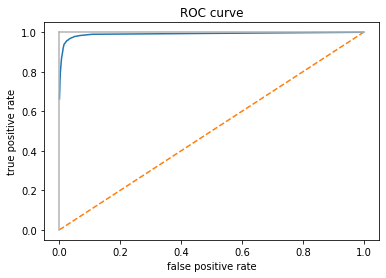

In [ ]:
cm1 = confusion_matrix(model5, failure_types, val_tuple, threshold1)
rates = roc_auc_report(cm1)
roc_curve(rates[0], rates[1])

In [ ]:
cm2 = confusion_matrix(model5, failure_types, val_tuple, threshold2)
metrics_report(cm2)

{'f1-measure': 0.9227758935559615,
 'precision': 0.9078542094455853,
 'recall': 0.9381962864721486}

The values of these 3 measures are comparable to those of model 3.

In [ ]:
prop = classes_proportion_correctly_classified(cm2, failure_types)
prop

{'Center': 0.8760932944606414,
 'Donut': 0.9438202247191011,
 'Edge-Loc': 0.905940594059406,
 'Edge-Ring': 0.9605688429217841,
 'Loc': 0.6719858156028369,
 'Near-full': 0.9166666666666666,
 'Random': 0.855072463768116,
 'Scratch': 0.6216216216216216,
 'none': 0.9845465111273729}

The classes that are most affected by the regularization are:

- Scratch about +7%;
- Loc about -11%.

In [ ]:
np.mean(list(prop.values()))

0.8595906705497275

Overall, the average of the percentages on the individual classes increased by approximately 0.3%.

Let's now consider a **decrease** in complexity, halving the number of filters for each layer. We also decrease the pooling window from 3x3 to 2x2.

## Save

Let's save the model.

In [ ]:
model5.save('/content/gdrive/MyDrive/DeepLearning/Models/model5')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/DeepLearning/Models/model5/assets


# Model 6: Decreasing complexity

### Network definition

In [ ]:
num_classes = 9
inputs = keras.Input((53, 52, 3)) 
he_init = tf.keras.initializers.HeNormal()

x = keras.layers.Conv2D(16, 3, padding = 'same', kernel_initializer = he_init)(inputs) 
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)  
x = keras.layers.MaxPooling2D(2, padding = "same")(x) 
x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_initializer = he_init)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(2, padding = "same")(x) 
x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_initializer = he_init)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.GlobalMaxPool2D()(x) 

outputs = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model6 = keras.Model(inputs, outputs)

In [ ]:
model6.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 53, 52, 3)]       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 53, 52, 16)        448       
                                                                 
 batch_normalization_6 (Batc  (None, 53, 52, 16)       64        
 hNormalization)                                                 
                                                                 
 activation_22 (Activation)  (None, 53, 52, 16)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 27, 26, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 27, 26, 32)        4640

In [ ]:
model6.compile(loss = keras.losses.categorical_crossentropy,
               optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
               metrics = ['accuracy'])

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

### Fitting

In [ ]:
history6 = model6.fit(train_aug_dataset, epochs = 100, validation_data = val_dataset, callbacks = [stop_early])

Epoch 1/100
6961/6961 [==============================] - 68s 10ms/step - loss: 0.4021 - accuracy: 0.8765 - val_loss: 0.1409 - val_accuracy: 0.9565
Epoch 2/100
6961/6961 [==============================] - 61s 9ms/step - loss: 0.2028 - accuracy: 0.9307 - val_loss: 0.1235 - val_accuracy: 0.9612
Epoch 3/100
6961/6961 [==============================] - 67s 10ms/step - loss: 0.1709 - accuracy: 0.9414 - val_loss: 0.1123 - val_accuracy: 0.9646
Epoch 4/100
6961/6961 [==============================] - 58s 8ms/step - loss: 0.1521 - accuracy: 0.9468 - val_loss: 0.1071 - val_accuracy: 0.9653
Epoch 5/100
6961/6961 [==============================] - 63s 9ms/step - loss: 0.1386 - accuracy: 0.9515 - val_loss: 0.1011 - val_accuracy: 0.9674
Epoch 6/100
6961/6961 [==============================] - 63s 9ms/step - loss: 0.1285 - accuracy: 0.9548 - val_loss: 0.0994 - val_accuracy: 0.9674
Epoch 7/100
6961/6961 [==============================] - 60s 9ms/step - loss: 0.1210 - accuracy: 0.9575 - val_loss: 0.0958

## Model analysis

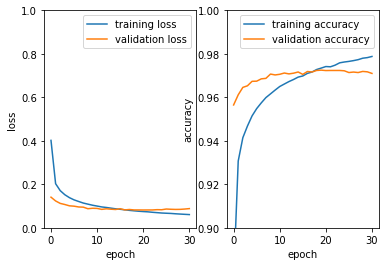

In [ ]:
plt.subplot(1,2,1)
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.legend(['training loss', 'validation loss'])

plt.subplot(1,2,2)
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0.9, 1])
plt.legend(['training accuracy', 'validation accuracy'])

Despite a slight worsening of the performances on the validation-set (compared to model3), we note a greater training stability and the almost absence of overfitting. In particular:

* Best val_loss: 0.0819 (+0.0011 compared to model 3).
* Best val_accuracy: 97.25% (-0.13% compared to model 3).

In [ ]:
print(topk_accuracy(model6, 1, val_tuple))
print(topk_accuracy(model6, 3, val_tuple))
print(topk_accuracy(model6, 5, val_tuple))

0.9709985
0.9981645
0.99988985


The value of the top1-accuracy has increased compared to model 5 and is substantially the same as obtained on model 3.

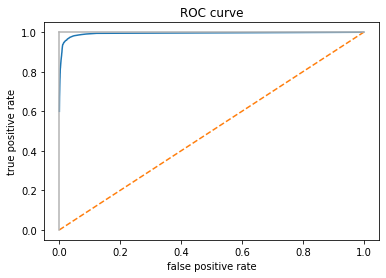

In [ ]:
cm1 = confusion_matrix(model6, failure_types, val_tuple, threshold1)
rates = roc_auc_report(cm1)
roc_curve(rates[0], rates[1])

In [ ]:
cm2 = confusion_matrix(model6, failure_types, val_tuple, threshold2)
metrics_report(cm2)

{'f1-measure': 0.9347998939835674,
 'precision': 0.9269382391590013,
 'recall': 0.9427960438385459}

The recall and f1-measure values are the highest obtained so far.

In [ ]:
prop = classes_proportion_correctly_classified(cm2, failure_types)
prop

{'Center': 0.8965014577259475,
 'Donut': 0.8651685393258427,
 'Edge-Loc': 0.870049504950495,
 'Edge-Ring': 0.9663865546218487,
 'Loc': 0.6471631205673759,
 'Near-full': 0.9166666666666666,
 'Random': 0.9057971014492754,
 'Scratch': 0.6756756756756757,
 'none': 0.9880332314579656}

The percentage for the *scratch* class is also the highest obtained among the various models, (approximately +5% compared to the model with L2 regularization). The *loc* class continues to be recognized worse than the previous models.

In [ ]:
np.mean(list(prop.values()))

0.859049094715677

The average of the percentages on the individual classes is the second highest obtained so far, lower than the one obtained on model5 (even if only by 0.05%).

We perform the **tuning** starting from this model, looking for the best combinations of learning-rate and L2 regularization.

## Save

Let's save the model.

In [ ]:
model6.save('/content/gdrive/MyDrive/DeepLearning/Models/model6')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/DeepLearning/Models/model6/assets


# Parameters tuning

Based on model 6, we now deal with the tuning of the parameters related to **learning-rate** and **regularization**. In particular:

* Learning-rate = [0.0001, 0.001].
* L2 regularization = [0, 1e-7, 1e-6, 1e-5].

In [ ]:
def build_model(hp):
  num_classes = 9
  inputs = keras.Input((53, 52, 3)) 
  he_init = tf.keras.initializers.HeNormal()

  x = keras.layers.Conv2D(16, 3, padding = 'same', kernel_initializer = he_init,
                          kernel_regularizer = tf.keras.regularizers.L2(hp.Choice('l2', [0.0, 1e-7, 1e-6, 1e-5])))(inputs) 
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)  
  x = keras.layers.MaxPooling2D(2, padding = "same")(x) 
  x = keras.layers.Conv2D(32, 3, padding = 'same', kernel_initializer = he_init, 
                          kernel_regularizer = tf.keras.regularizers.L2(hp.Choice('l2', [0.0, 1e-7, 1e-6, 1e-5])))(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.MaxPooling2D(2, padding = "same")(x) 
  x = keras.layers.Conv2D(64, 3, padding = 'same', kernel_initializer = he_init, 
                          kernel_regularizer = tf.keras.regularizers.L2(hp.Choice('l2', [0.0, 1e-7, 1e-6, 1e-5])))(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Activation('relu')(x)
  x = keras.layers.GlobalMaxPool2D()(x) 

  outputs = keras.layers.Dense(num_classes, activation = 'softmax', 
                          kernel_regularizer = tf.keras.regularizers.L2(hp.Choice('l2', [0.0, 1e-7, 1e-6, 1e-5])))(x)

  model5 = keras.Model(inputs, outputs)

  model5.compile(loss = keras.losses.categorical_crossentropy,
               optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', [0.0001, 0.001])),
               metrics = ['accuracy'])

  return model5

In [ ]:
tuner = kt.RandomSearch(build_model, objective = 'val_loss')

In [ ]:
tuner.search(train_aug_dataset, epochs = 10, validation_data = val_dataset)

The best parameters for learning-rate and L2 regularization are, respectively, **0.0001** and **0**, i.e. the parameters of model6.

# Evaluation on the test-set

We conclude with an evaluation on the test-set in order to verify the generalization performance.

In [ ]:
model6 = keras.models.load_model('/content/gdrive/MyDrive/DeepLearning/Models/model6')

In [ ]:
model6.evaluate(test_dataset)

1065/1065 [==============================] - 82s 77ms/step - loss: 0.0884 - accuracy: 0.9707


[0.08843439817428589, 0.9706608057022095]

We also report the values obtained on training-set and validation-set from the final model:

- train_loss: 0.0608
- train_accuracy: 0.9788
- val_loss: 0.0882
- val_accuracy: 0.9710

We deduce that the model has a good generalization capacity.

In [ ]:
test_tuple = from_DataBatch_to_list(test_dataset)

In [ ]:
print(topk_accuracy(model6, 1, test_tuple))
print(topk_accuracy(model6, 3, test_tuple))
print(topk_accuracy(model6, 5, test_tuple))

0.9706608
0.998326
0.9999706


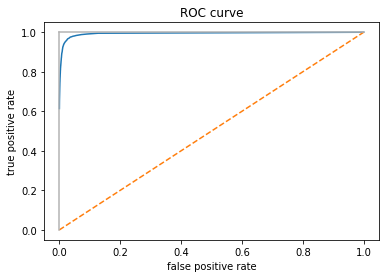

In [ ]:
cm1 = confusion_matrix(model6, failure_types, test_tuple, threshold1)
rates = roc_auc_report(cm1)
roc_curve(rates[0], rates[1])

In [ ]:
cm2 = confusion_matrix(model6, failure_types, test_tuple, threshold2)
metrics_report(cm2)

{'f1-measure': 0.9291421362489488,
 'precision': 0.9225469728601252,
 'recall': 0.9358322744599746}

In [ ]:
prop = classes_proportion_correctly_classified(cm2, failure_types)
prop

{'Center': 0.9171528588098017,
 'Donut': 0.7837837837837838,
 'Edge-Loc': 0.8553022794846382,
 'Edge-Ring': 0.9570615623383342,
 'Loc': 0.705547652916074,
 'Near-full': 0.9333333333333333,
 'Random': 0.9244186046511628,
 'Scratch': 0.646551724137931,
 'none': 0.987222317892199}

Even the percentage values on the individual classes are comparable. The biggest difference is found on the *donut* class:

- *Center*: 0.8965014577259475,
- *Donut*: 0.8651685393258427,
- *Edge-Loc*: 0.870049504950495,
- *Edge-Ring*: 0.9663865546218487,
- *Loc*: 0.6471631205673759,
- *Near-full*: 0.9166666666666666,
- *Random*: 0.9057971014492754,
- *Scratch*: 0.6756756756756757,
- *none*: 0.9880332314579656.

(In the list the values obtained on the validation set).

In [ ]:
np.mean(list(prop.values()))

0.8567082352608063

Even the average percentage on the single classes is similar to the one obtained previously on the validation-set, which was equal to:

- 85.90% (+ 0.23%).